# Import & Function Defination

## Import modules & Variable defination

In [1]:
import pandas as pd
import numpy as np
import math
import json
from dtaidistance import dtw
from threading import Thread
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tslearn.barycenters import dtw_barycenter_averaging
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.signal import butter, filtfilt

# Global variables
number_of_participants_for_experiment1 = 6
number_of_stimuli_for_experiment1 = 4
number_of_color_combinations_for_experiment1 = 4

number_of_participants_for_experiment2 = 5
number_of_stimuli_for_experiment2 = 8

FREQUENCY = 50

In [2]:
# Store participant's experiment data for experiment1. This is a three dimension array which follows the structure like 
# [participant 1[stimulus 1[color variations 1, ...], stimulus 2[...], ...],
#  participant 2[...],
#  ...]
participants_data_for_experiment1 = [
    [
        [[] for _ in range(number_of_color_combinations_for_experiment1)] 
        for _ in range(number_of_stimuli_for_experiment1)
    ]
    for _ in range(number_of_participants_for_experiment1)
]
DBA_for_experiment1 = [
    [
        [[] for _ in range(number_of_participants_for_experiment1)] 
        for _ in range(number_of_color_combinations_for_experiment1) 
    ]
    for _ in range(number_of_stimuli_for_experiment1)
]
EER_for_experiment1 = [
    [
        [[] for _ in range(number_of_participants_for_experiment1)] 
        for _ in range(number_of_color_combinations_for_experiment1) 
    ]
    for _ in range(number_of_stimuli_for_experiment1)
]

# Store participant's experiment data for experiment2. This is a two dimension array which follows the structure like 
# [participant 1[stimulus 1, stimulus 2, ...],
#  participant 2[...],
#  ...]
participants_data_for_experiment2 = [
    [
        [] for _ in range(number_of_stimuli_for_experiment2)
    ]
    for _ in range(number_of_participants_for_experiment2)
]
DBA_for_experiment2 = [
    [
        [] for _ in range(number_of_stimuli_for_experiment2)
    ]
    for _ in range(number_of_participants_for_experiment2)
]
EER_for_experiment2 = [
    [
        [] for _ in range(number_of_stimuli_for_experiment2)
    ]
    for _ in range(number_of_participants_for_experiment2)
]


## File Reading

In [3]:
'''
Search for starting indices of every experiment. Then, divive a CSV file using starting indices into experiments

    Args:
        experiment_df(data frame): the experiment csv file

    Returns: 
        array: stores all starting indices
'''
def divide_experiments(experiment_df):
    recording_timestamps = experiment_df['Recording timestamp']
    starting_indices = []
    
    previous_recording_timestamp = recording_timestamps[0]
    starting_indices.append(0)
    
    for index in range(len(recording_timestamps)):
        if index == len(recording_timestamps) - 1:
            break
        # read the next recording timestamp
        next_recording_timestamp = recording_timestamps[index + 1]
        # if the difference between two adjacent numbers is not equal to 20
        # store the next index. That is the starting index of next data series
        difference = next_recording_timestamp - previous_recording_timestamp
        if difference < 19 or difference > 21:
            starting_indices.append(index + 1)
        previous_recording_timestamp = next_recording_timestamp

    experiments_df = []
    for index in range(len(starting_indices)):
        starting_loc = starting_indices[index]
        ending_loc = starting_indices[index+1] if index != len(starting_indices)-1 else len(experiment_df)  
        experiments_df.append(experiment_df.iloc[starting_loc:ending_loc])

    print(starting_indices)
    return experiments_df

def divide_into_single_trial_for_experiment1(color_df, preparation_duration, experiment_duration, number_of_trials):
    """
    Divide one color-combination DataFrame into single trials.
    Returns a list of NumPy arrays.
    """

    prep_samples = int(preparation_duration * FREQUENCY)
    exp_samples = int(experiment_duration * FREQUENCY)
    samples_per_trial = prep_samples + exp_samples

    single_trials = []

    for trial_index in range(number_of_trials):
        start_idx = trial_index * samples_per_trial
        end_idx = start_idx + samples_per_trial

        trial_df = color_df.iloc[start_idx:end_idx]

        # convert to NumPy as required by your pipeline
        single_trials.append(trial_df.to_numpy())

    return single_trials

def divide_into_single_trial_for_experiment2(experiment, stimulus_index, preparation_duration, experiment_duration, number_of_trials):
    trials = []
    number_of_sample_in_preparation = preparation_duration * FREQUENCY
    number_of_sample_in_experiment = 67 if stimulus_index == 2 else experiment_duration * FREQUENCY
    total_number_of_sample = number_of_sample_in_preparation + number_of_sample_in_experiment
    
    for attempt in range(number_of_trials): 
        attempt = attempt + 1 # 2
        trials.append(experiment.iloc[
                        (attempt - 1) * total_number_of_sample + number_of_sample_in_preparation :
                        (attempt - 1) * total_number_of_sample + total_number_of_sample]) 
    return trials

def load_data_for_experiment1(file_path):
    # The experiments vary in preparation duration, experiment duration and the number of trials
    preparation_duration = [5, 5, 5, 5]
    experiment_duration = [5, 5, 7, 6]
    number_of_trials = [10, 10, 10, 10]

    # There are six participants
    for participant_index in range(number_of_participants_for_experiment1):
        # Each participant has to conduct four experiments
        for experiment_index in range(number_of_stimuli_for_experiment1):
            # Load experiment data file
            experiment_file_path = file_path + '\\Participant' + str(participant_index + 1) + '\\E' + str(experiment_index + 1) + '.csv'
            experiment_df = pd.read_csv(experiment_file_path)
            # Divide data into four color combinations
            color_combo = divide_experiments(experiment_df)
            # Each experiment has four color combinations
            for color_combo_index in range(number_of_color_combinations_for_experiment1):
                single_trial_data = divide_into_single_trial_for_experiment1(
                    color_combo[color_combo_index],
                    preparation_duration[experiment_index],
                    experiment_duration[experiment_index],
                    number_of_trials[experiment_index]
                )
                participants_data_for_experiment1[participant_index][experiment_index][color_combo_index] = single_trial_data

def load_data_for_experiment2(file_path):
    for participant_index in range(number_of_participants_for_experiment2):
        # Each participant has to conduct four experiments
        for stimulus_index in range(number_of_stimuli_for_experiment2):
            # Load experiment data file
            experiment_file_path = file_path + '\\Participant' + str(participant_index + 1) + '\\Stimulus' + str(stimulus_index + 1) + '.csv'
            experiment_df = pd.read_csv(experiment_file_path)
            participants_data_for_experiment2[participant_index][stimulus_index] = divide_into_single_trial_for_experiment2(experiment_df, stimulus_index, 2, 2, 50)


In [4]:
'''
This is an internal function. This function plots pupil size changes on both sites
'''
def _plot0(recording_timestamp, pupil_diameter_left, pupil_diameter_right):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(recording_timestamp - recording_timestamp.iloc[1], pupil_diameter_left, color='red', linewidth=2)
    ax1.set_title('Pupil Diameter Left')
    ax1.set_xlabel('Timestamp(ms)', fontsize=12)
    ax1.set_ylabel('Diameter(mm)', fontsize=12)
    ax1.grid(True)
    ax2.plot(recording_timestamp - recording_timestamp.iloc[1], pupil_diameter_right, color='blue', linewidth=2)
    ax2.set_title('Pupil Diameter Right')
    ax2.set_xlabel('Timestamp(ms)', fontsize=12)
    ax2.set_ylabel('Diameter(mm)', fontsize=12)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def _plot_single(data_frame):
    _plot0(data_frame['Recording timestamp'], data_frame['Pupil diameter left'], data_frame['Pupil diameter right'])

'''
Plots all pupil diameter's changes from a color variations
'''
def plot(data_frame):
    for i in range(len(data_frame)):
        _plot_single(data_frame[i])

def _plot_DBA(DBA):
    timestamps = np.arange(0, 10000, 20)  # This creates [0, 20, 40, ..., 2000]

    # Flatten your pupil diameter arrays if they're 2D
    left_pupil = DBA[0].flatten()
    right_pupil = DBA[1].flatten()
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Recording timestamp': timestamps[:len(left_pupil)],  # Match the length of your data
        'Pupil diameter left': left_pupil,
        'Pupil diameter right': right_pupil
    })
    
    _plot_single(df)


## Data Pre-Processing

In [5]:
# for test

def dataframe_fft(df, fs):
    """
    Apply FFT to each column of a DataFrame.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Time-domain signal. Each column is one signal.
    fs : float
        Sampling frequency (Hz).
    
    Returns
    -------
    freqs : numpy.ndarray
        Frequency axis.
    fft_df : pandas.DataFrame
        FFT magnitude for each column.
    """
    n = len(df)
    freqs = np.fft.rfftfreq(n, d=1/fs)

    fft_values = np.fft.rfft(df.values, axis=0)
    fft_magnitude = np.abs(fft_values)

    fft_df = pd.DataFrame(fft_magnitude, index=freqs, columns=df.columns)

    return freqs, fft_df

def lowpass_2hz_test(df, fs=FREQUENCY, order=4):
    cutoff = 2
    nyq = fs / 2
    normal_cutoff = cutoff / nyq

    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Separate timestamp and signals
    timestamp = df["Recording timestamp"]
    signals = df[["Pupil diameter left", "Pupil diameter right"]]

    filtered = filtfilt(b, a, signals.values, axis=0)

    df_filtered = pd.DataFrame(
        filtered,
        columns=signals.columns,
        index=signals.index
    )

    # Reattach timestamp
    df_filtered["Recording timestamp"] = timestamp

    return df_filtered

In [6]:
def lowpass_2hz(signal_list, fs=FREQUENCY, order=4):
    cutoff = 2
    nyq = fs / 2
    normal_cutoff = cutoff / nyq
    filtered_signals = []

    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    for signal in signal_list:
        filtered = filtfilt(b, a, signal.values, axis=0)
        filtered_signals.append(filtered)  

    return filtered_signals

'''
extract left pupil and right pupil data into two lists
'''
def gen_series_list(experiments_data_frame):
    left_eye_series_list = []
    right_eye_series_list = []
    for exp in experiments_data_frame:
        left_eye_series_list.append(exp['Pupil diameter left'].to_numpy())
        right_eye_series_list.append(exp['Pupil diameter right'].to_numpy())
    return left_eye_series_list, right_eye_series_list

def preprocess_data_for_experiment2():
    """
    Preprocess pupil data by applying linear interpolation and 2Hz lowpass filtering.
    """
    for stimulus_idx in range(len(participants_data_for_experiment2)):
        for participant_idx in range(len(participants_data_for_experiment2[stimulus_idx])):
            processed_dataframes = []
            
            for df in participants_data_for_experiment2[stimulus_idx][participant_idx]:
                # Extract left and right pupil series
                raw_left_series = df['Pupil diameter left']
                raw_right_series = df['Pupil diameter right']
                
                # Apply linear interpolation
                interpolated_left = raw_left_series.interpolate().ffill().bfill()
                interpolated_right = raw_right_series.interpolate().ffill().bfill()
                
                # Apply 2 Hz lowpass filtering
                filtered_left = lowpass_2hz([interpolated_left])[0]
                filtered_right = lowpass_2hz([interpolated_right])[0]
                
                # Create new dataframe with processed data
                processed_df = df.copy()
                processed_df['Pupil diameter left'] = filtered_left
                processed_df['Pupil diameter right'] = filtered_right
                
                processed_dataframes.append(processed_df)
            
            # Replace the original data with processed data
            participants_data_for_experiment2[stimulus_idx][participant_idx] = processed_dataframes

## Data Processing

In [7]:
def generate_DBA_for_experiment_2():
    """
    Generate DBA (DTW Barycenter Averaging) for each stimulus for each participant in experiment 2.
    Reads from participants_data_for_experiment2 and stores results in DBA_for_experiment2.
    """
    for participant_idx in range(number_of_participants_for_experiment2):
        for stimulus_idx in range(number_of_stimuli_for_experiment2):
            print(f"processing participant_idx={participant_idx + 1}, stimulus_idx={stimulus_idx + 1} ... ")
            # Get the data for this participant and stimulus
            data = participants_data_for_experiment2[participant_idx][stimulus_idx]

            # Separate left and right eye data
            left_eye_series_list = []
            right_eye_series_list = []
            
            for trial in data:
                # Assuming each trial contains left and right eye data
                # Adjust indexing based on your actual data structure
                left_eye_series_list.append(trial["Pupil diameter left"])  # Left eye data
                right_eye_series_list.append(trial["Pupil diameter right"])  # Right eye data

            # Store the result at the same index
            DBA_for_experiment2[participant_idx][stimulus_idx] = [
                dtw_barycenter_averaging(left_eye_series_list, verbose=False), 
                dtw_barycenter_averaging(right_eye_series_list, verbose=False)
            ]

            print(f"Done!")

In [8]:
def gen_DTW(time_series_list, barycenter, max_workers=None):
    """
    Calculate DTW distance between each time series in the list and the barycenter
    using multithreading.
    
    Parameters:
    -----------
    time_series_list : list
        List of time series sequences (e.g., 50 sequences)
    barycenter : array-like
        The barycenter sequence to compare against
    max_workers : int, optional
        Maximum number of threads. If None, defaults to number of processors on the machine
    
    Returns:
    --------
    list
        List of DTW distances in the same order as input
    """
    def calculate_single_dtw(series, barycenter):
        print("*", end="")
        return dtw.distance(np.array(series).reshape(-1, 1), barycenter)
    
    dtw_distances = [None] * len(time_series_list)
    
    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks and store futures with their indices
        future_to_index = {
            executor.submit(calculate_single_dtw, series, barycenter): i
            for i, series in enumerate(time_series_list)
        }
        
        # Collect results as they complete
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                dtw_distances[index] = future.result()
            except Exception as exc:
                print(f'Series at index {index} generated an exception: {exc}')
                dtw_distances[index] = None

    print("")
    return dtw_distances

def get_threshold(list_A, list_B, barycenter_A):
    target_DTWs = gen_DTW(list_A, barycenter_A) 
    other_DTWs = gen_DTW(list_B, barycenter_A)
    
    # Check if we have valid data
    if len(target_DTWs) == 0 or len(other_DTWs) == 0:
        raise ValueError("Empty DTW distance lists - cannot compute EER")
    
    # Sort the distance lists
    target_DTWs.sort()
    other_DTWs.sort()

    # Determine the range for thresholds
    min_val = min(target_DTWs[0], other_DTWs[0])
    max_val = max(target_DTWs[-1], other_DTWs[-1])
    
    # Check if min_val and max_val are valid for creating a range
    if min_val >= max_val:
        # Handle degenerate case: all distances are the same or very close
        print(f"Warning: min_val ({min_val}) >= max_val ({max_val}). Using single threshold.")
        # Use a small range around the single value
        thresholds = [min_val - 0.01, min_val, min_val + 0.01]
    else:
        # Generate dense thresholds array
        # Using a dense array ensures smoother FAR/FRR curves
        thresholds = np.arange(min_val, max_val + 0.01 / 2, 0.01).tolist()
    
    # FRR (False Rejection Rate): The target user is wrongly rejected.
    # Count of 'target' samples where DTW > threshold (Rejection)
    FAR = []
    for i in range(len(thresholds)):
        # Number of samples from 'other_DTWs' that are mistakenly accepted
        num_FAR = sum(1 for dist in other_DTWs if dist <= thresholds[i])
        FAR.append(num_FAR / len(other_DTWs))
    
    # FRR (False Rejection Rate): The target user is wrongly rejected.
    # Count of 'target' samples where DTW > threshold (Rejection)
    FRR = []
    for i in range(len(thresholds)):
        # Number of samples from 'target_DTWs' that are mistakenly rejected
        num_FRR = sum(1 for dist in target_DTWs if dist > thresholds[i])
        FRR.append(num_FRR / len(target_DTWs))
    
    plt.figure(figsize=(10, 6)) 
    plt.plot(thresholds, FAR, label='FAR (False Acceptance Rate)', color='red')
    plt.plot(thresholds, FRR, label='FRR (False Rejection Rate)', color='blue')
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Error Rate (%)') 
    plt.title('FAR vs. FRR Curves') 
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.legend() 
    
    # find the EER point (where |FAR - FRR| is minimized)
    min_diff = float('inf')
    eer_index = -1
    
    # find the point with the minimum difference between FRR and FAR
    for i in range(len(thresholds)):
        diff = abs(FAR[i] - FRR[i])
        if diff < min_diff:
            min_diff = diff
            eer_index = i
    
    # Calculate EER values and plot
    if eer_index != -1:
        eer_threshold = thresholds[eer_index]
        # EER value is the average of FAR and FRR at the crossing point
        eer_value = (FAR[eer_index] + FRR[eer_index]) / 2.0
    
        # Plot the EER point
        plt.plot(eer_threshold, eer_value, 'go', markersize=10, label='EER Point')
        
        # Draw a perpendicular line for the EER threshold
        plt.axvline(eer_threshold, color='gray', linestyle=':', linewidth=1.5,
                    label=f'EER Threshold: {eer_threshold:.2f}')
    
        # Add a label showing the EER point details
        if max_val > min_val:
            xtext_offset = (max_val - min_val) * 0.02
        else:
            xtext_offset = 0.01
            
        ytext_offset = (plt.ylim()[1] - plt.ylim()[0]) * 0.05
    
        plt.text(eer_threshold + xtext_offset, eer_value + ytext_offset,
                 f'Threshold: {eer_threshold:.2f}\nEER: {eer_value:.2f}',
                 color='green', fontsize=10, ha='left', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=0.5, alpha=0.6))
        
        plt.legend()
    else:
        eer_value = 0.5  # Default value if EER cannot be computed
        
    FAR.sort()
    FRR.sort()
    # Dynamically set Y-axis limit
    max_y = max(FAR[-1], FRR[-1])
    plt.ylim(0, max_y + 0.05)
    
    plt.show()
    
    return eer_value

## EER Computation

In [9]:
def compute_EER(): 
    
    # There are four experiments
    for experiment_index in range(number_of_stimuli_for_experiment1):

        # Each experiment has four color combinations
        for color_index in range(number_of_color_combinations_for_experiment1):

            # Each color variations involves six participants
            for participant_index in range(number_of_participants_for_experiment1):

                # Each participant has to compare their data to other five participant's data
                for another_participant_index in range(number_of_participants_for_experiment1):
                    if participant_index == another_participant_index:
                        continue
                    target_data = participants_data_for_experiment1[participant_index][experiment_index][color_index]
                    others_data = participants_data_for_experiment1[another_participant_index][experiment_index][color_index]
                    results = compare_two_participants(target_data, others_data)
                    EER_for_experiment1[experiment_index][color_index][participant_index].append(results)

                    print(f"[Info] Experiment {experiment_index}, color variations {color_index}, Participant {participant_index} with Participant {another_participant_index}: Done")
                    print(f"[Info] Left EER: {results[0]}, Right EER: {results[1]}")
                print(f"[Info] participant_index: {participant_index}: Done")
            print(f"[Info] color_index: {color_index}: Done")
        print(f"[Info] experiment_index: {experiment_index}: Done")
        print("————————————————————————————————————————————————————————")

In [10]:
def compute_threshold_for_experiment2():
    """
    Compute EER thresholds by comparing each participant's data against all other participants.
    
    Args:
        participants_data_for_experiment2: Genuine data for each participant and stimulus
        DBA_for_experiment2: Impostor data (Data By Attackers) for comparison
        EER_for_experiment2: Output array to store EER results
        number_of_participants_for_experiment2: Total number of participants
        number_of_stimuli_for_experiment2: Total number of stimuli/experiments
    """
    # Each participant
    for target_subject_index in range(number_of_participants_for_experiment2):
        # Each stimulus/experiment
        for stimulus_index in range(number_of_stimuli_for_experiment2):    
            left_eye_data_from_target_subject = []
            right_eye_data_from_target_subject = []
            left_eye_data_from_another_participant = []
            right_eye_data_from_another_participant = []
            
            data_from_target_subject = participants_data_for_experiment2[target_subject_index][stimulus_index]
            DBA = DBA_for_experiment2[target_subject_index][stimulus_index]
            
            for data in data_from_target_subject:
                left_eye_data_from_target_subject.append(data["Pupil diameter left"])
                right_eye_data_from_target_subject.append(data["Pupil diameter right"])
            
            # Compare this participant against all other participants
            for another_participant_index in range(number_of_participants_for_experiment2):
                # Skip comparing participant with themselves
                if target_subject_index == another_participant_index:
                    continue
                
                data_from_another_participant = participants_data_for_experiment2[another_participant_index][stimulus_index]
                
                for data in data_from_another_participant:
                    left_eye_data_from_another_participant.append(data["Pupil diameter left"])
                    right_eye_data_from_another_participant.append(data["Pupil diameter right"])

            # Compare the two participants' data
            left_eye_EER = get_threshold(left_eye_data_from_target_subject, left_eye_data_from_another_participant, DBA[0])
            right_eye_EER = get_threshold(right_eye_data_from_target_subject, right_eye_data_from_another_participant, DBA[1])
            EER = (left_eye_EER + right_eye_EER) / 2
            
            # Store the EER results for this stimulus and participant
            EER_for_experiment2[target_subject_index][stimulus_index] = EER
            
            # Print progress information
            print(f"Under stimulus {stimulus_index + 1}, Participant {target_subject_index + 1} vs Participant {another_participant_index + 1}: EER = {EER}")

# Read Experiment Data

## Experiment1

In [ ]:
file_path = 'D:\\University\\manaba\\murao\\B4\\pupil_diameter\\Investigation-of-the-Feasibility-of-Individual-Identification-Based-on-Pupil-Diameter-Changes-Caused\\Data\\Experiment1'
load_data_for_experiment1(file_path)

## Experiment2

In [11]:
file_path = 'D:\\University\\manaba\\murao\\B4\\pupil_diameter\\Investigation-of-the-Feasibility-of-Individual-Identification-Based-on-Pupil-Diameter-Changes-Caused\\Data\\Experiment2'
load_data_for_experiment2(file_path)

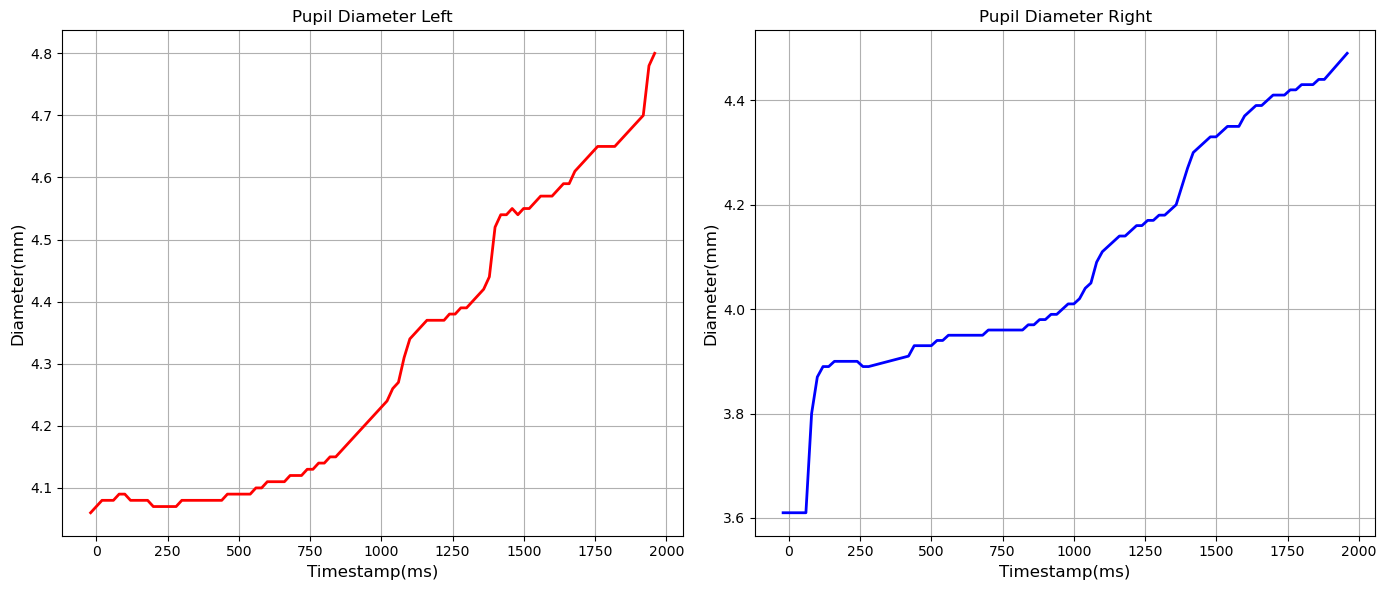

In [21]:
_plot(participants_data_for_experiment2[0][5])

In [148]:
order = 1
for each in participants_data_for_experiment2[4][5]:
    if each.isna().any().any():
        print(f"order={order} has NaN")
    order += 1

In [ ]:
_plot_single(participants_data_for_experiment2[3][4][34])

In [ ]:
# A Test for 2 Hz lowpass filter
df_before = participants_data_for_experiment2[4][7][12].interpolate().ffill().bfill()
df_after = lowpass_2hz_test(df_before)
_plot_single(df_before)
_plot_single(df_after)

# Data Preprocessing

## Experiment 2

In [147]:
preprocess_data_for_experiment2()

In [ ]:
generate_DBA_for_experiment_2()

In [ ]:
_plot_DBA(DBA_for_experiment2[0][0])

# Evaluation

## Experiment 1

### Compute for the first time

In [ ]:
preprocess_data_for_experiment1()

### Read & Store EERs with .json

In [ ]:
# with open("EER_data.json", 'w') as f:
#     # indent=4 で整形して読みやすくする
#     json.dump(EER_for_experiment1, f, indent=4)

In [ ]:
with open("EER_data.json", 'r') as f:
        EER_for_experiment1 = json.load(f)

### Mean EER of specific pattern or color using Two-side EER

In [ ]:
for experiment_index in range(number_of_stimuli_for_experiment1):
    sum_of_EER = 0
    for color_combination_index in range(number_of_color_combinations_for_experiment1):
        for participant_index in range(number_of_participants_for_experiment1):
            for comparison_index in range(number_of_participants_for_experiment1 - 1):
                current_EER = EER_for_experiment1[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sum_of_EER = sum_of_EER + average_of_left_and_right
        # print(f"experiment_index is {experiment_index}, color_combination_index is {color_combination_index}, sum_of_EER is {sum_of_EER}")
    print(f"[Info] The average EER of experiment {experiment_index} is {sum_of_EER / (number_of_color_combinations_for_experiment1 * number_of_participants_for_experiment1 * (number_of_participants_for_experiment1 - 1))}")

In [ ]:
sums = [0] * number_of_color_combinations_for_experiment1

for experiment_index in range(number_of_stimuli_for_experiment1):
    for color_combination_index in range(number_of_color_combinations_for_experiment1):    
        for participant_index in range(number_of_participants_for_experiment1):
            for comparison_index in range(number_of_participants_for_experiment1 - 1):
                current_EER = EER_for_experiment1[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sums[color_combination_index] += average_of_left_and_right
          
divisor = number_of_stimuli_for_experiment1 * number_of_participants_for_experiment1 * (number_of_participants_for_experiment1 - 1)
for i in range(number_of_color_combinations_for_experiment1):
    average_EER = sums[i] / divisor
    print(f"[Info] The average EER of color variations {i+1} is {average_EER}")

### Best one among 16 stimuli for each participant

In [ ]:
participants_EER = [
    [
        []for _ in range(number_of_stimuli_for_experiment1 * number_of_color_combinations_for_experiment1)
    ]
    for _ in range(number_of_participants_for_experiment1)
]

for experiment_index in range(number_of_stimuli_for_experiment1):
    for color_combination_index in range(number_of_color_combinations_for_experiment1):    
        for participant_index in range(number_of_participants_for_experiment1):
            sum_temp = 0
            # The sum EER of comparing with other five participants
            for comparison_index in range(number_of_participants_for_experiment1 - 1):
                current_EER = EER_for_experiment1[experiment_index][color_combination_index][participant_index][comparison_index]
                average_of_left_and_right = (current_EER[0] + current_EER[1]) / 2
                sum_temp += average_of_left_and_right
            # The mean EER of it
            # color variations 1 of experiment 1 = 1, color variations 2 of experiment 1 = 2, ...
            # color variations 1 of experiment 2 = 5, color variations 2 of experiment 2 = 6, ...
            participants_EER[participant_index][(experiment_index - 1) * 4 + color_combination_index] = sum_temp / (number_of_participants_for_experiment1 - 1)


for participant_index in range(number_of_participants_for_experiment1):
    min_EER = math.inf
    min_index = -1
    for stimulus_index in range(number_of_stimuli_for_experiment1 * number_of_color_combinations_for_experiment1):
        current_EER = participants_EER[participant_index][stimulus_index]
        if current_EER < min_EER:
            min_EER = current_EER
            min_index = stimulus_index + 1
    # print(f"The lowest EER for participant {participant_index} equals {min_EER} at min_index {min_index}")
    which_experiment = int(min_index / 4 + 1)
    which_color_combination = min_index - (which_experiment - 1) * 4
    print(f"The lowest EER for participant {participant_index} equals {min_EER} at experiment {which_experiment}, color variations {which_color_combination}")

In [ ]:
participants_EER

## Experiment 2

**************************************************
********************************************************************************************************************************************************************************************************


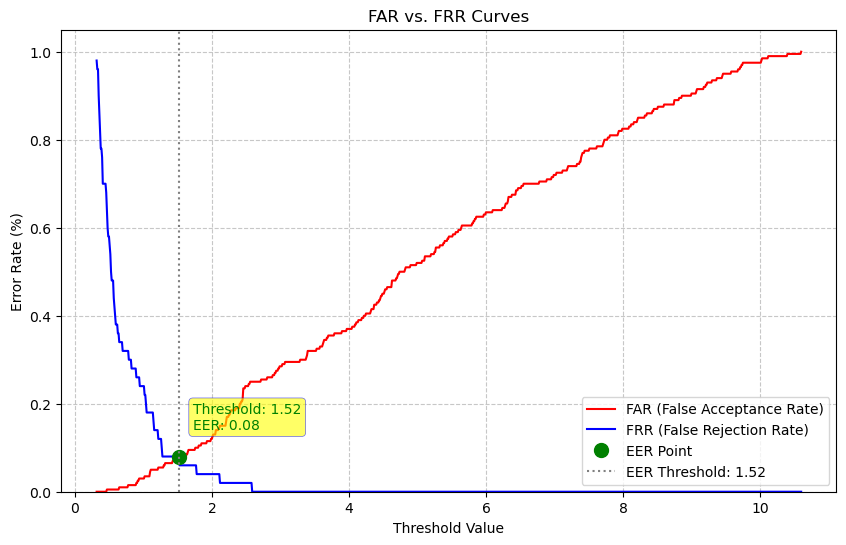

**************************************************
********************************************************************************************************************************************************************************************************


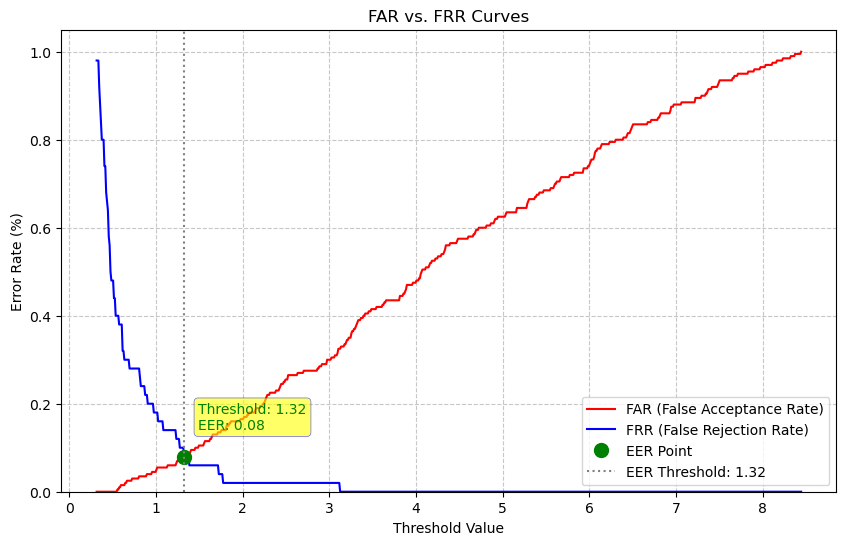

Under stimulus 1, Participant 1 vs Participant 5: EER = 0.08
**************************************************
********************************************************************************************************************************************************************************************************


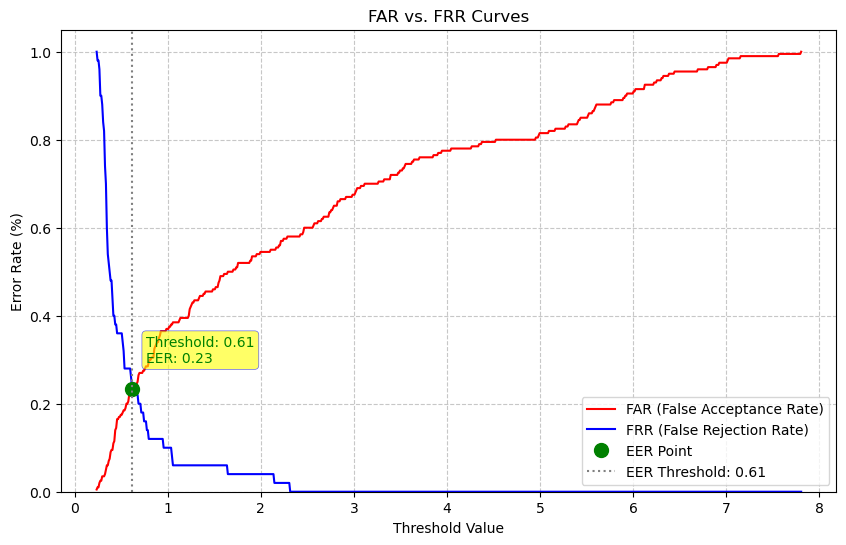

**************************************************
********************************************************************************************************************************************************************************************************


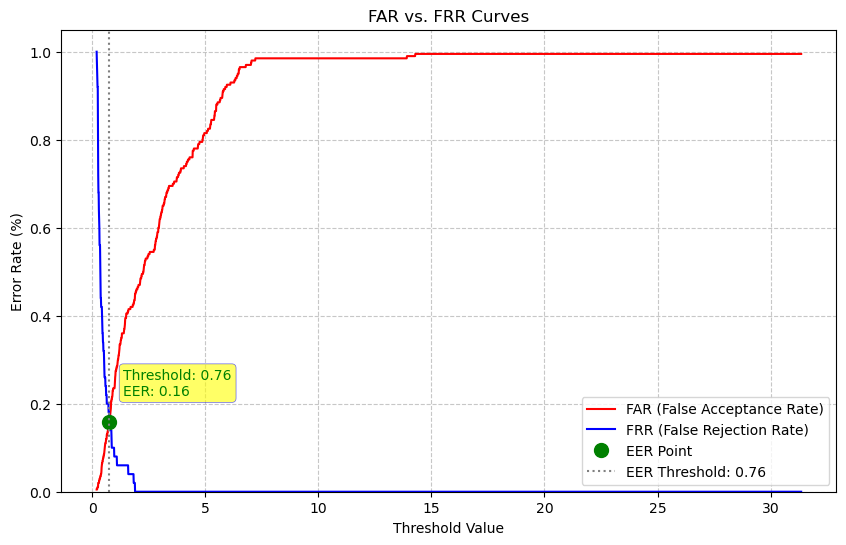

Under stimulus 2, Participant 1 vs Participant 5: EER = 0.195
**************************************************
********************************************************************************************************************************************************************************************************


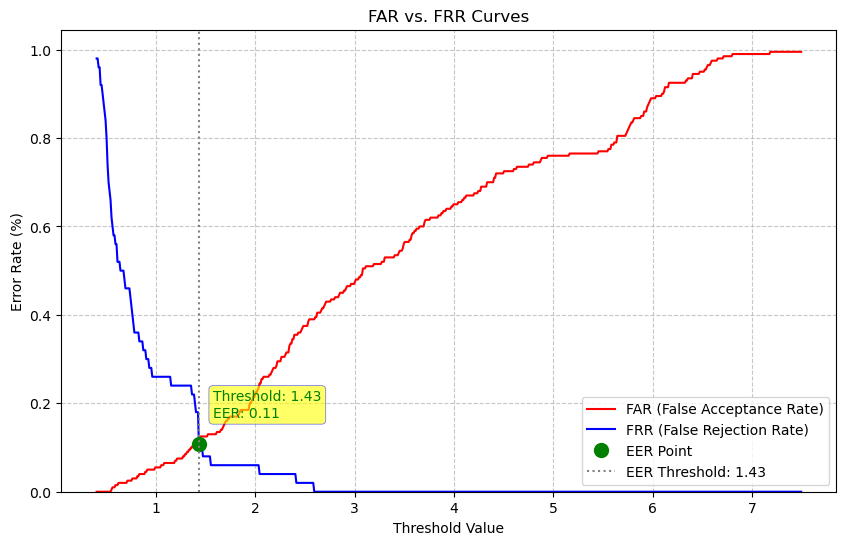

**************************************************
********************************************************************************************************************************************************************************************************


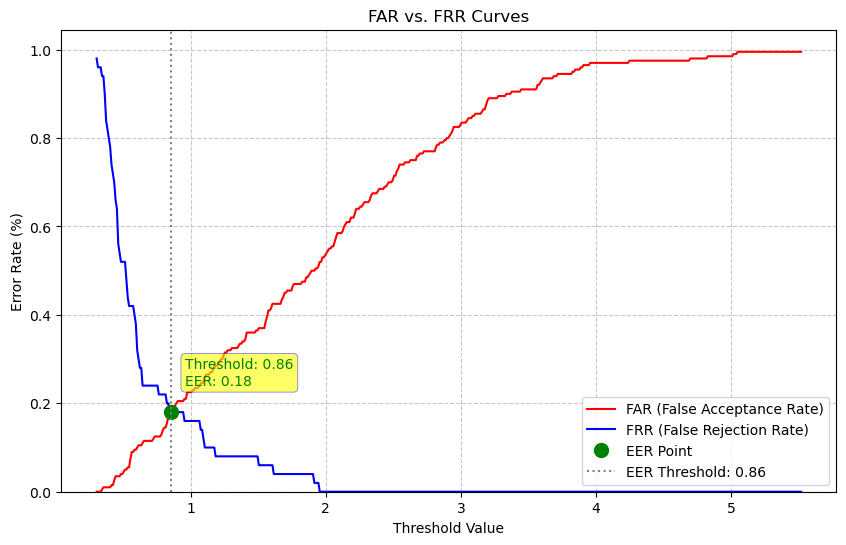

Under stimulus 3, Participant 1 vs Participant 5: EER = 0.14375
**************************************************
********************************************************************************************************************************************************************************************************


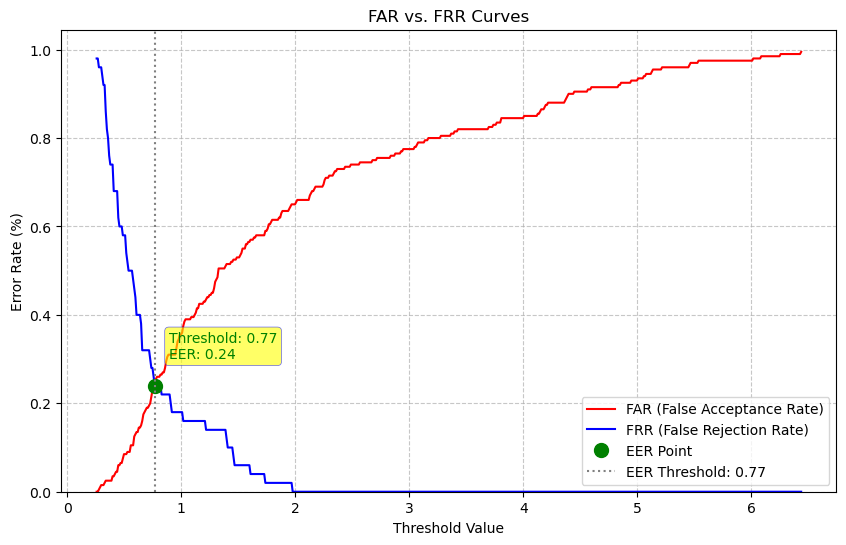

**************************************************
********************************************************************************************************************************************************************************************************


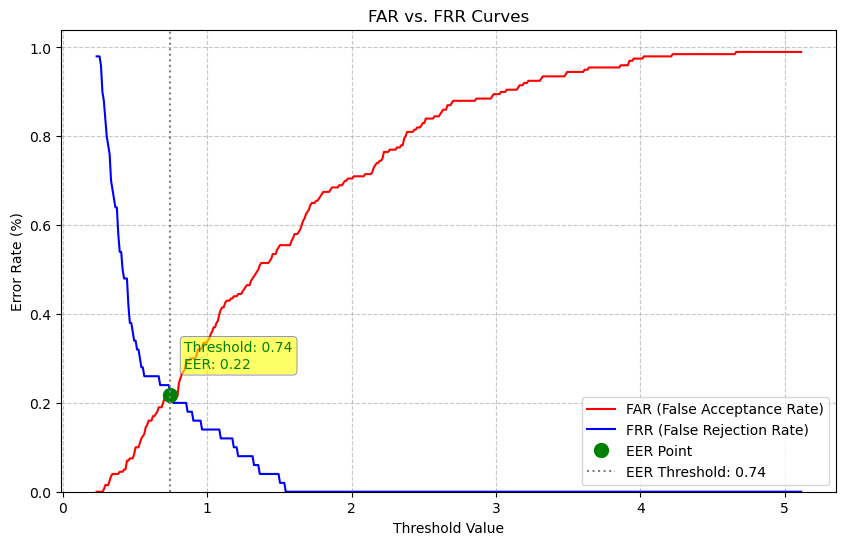

Under stimulus 4, Participant 1 vs Participant 5: EER = 0.22875
**************************************************
********************************************************************************************************************************************************************************************************


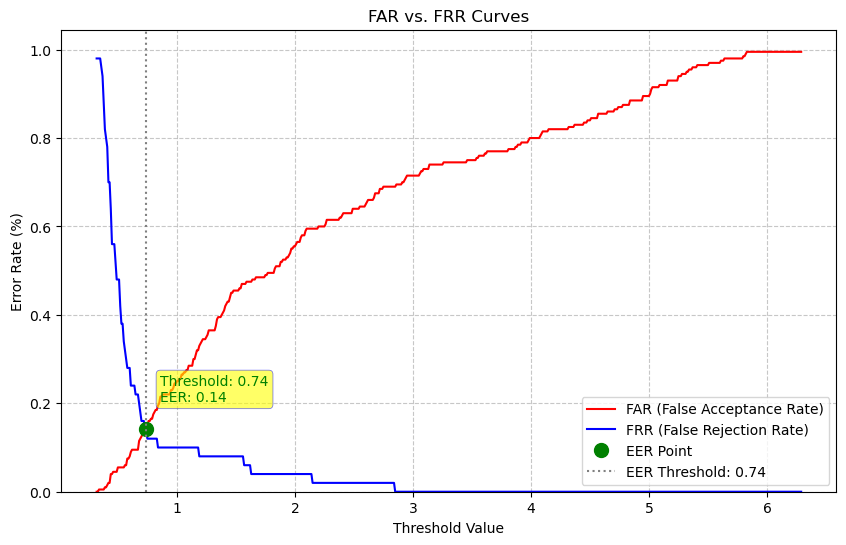

**************************************************
********************************************************************************************************************************************************************************************************


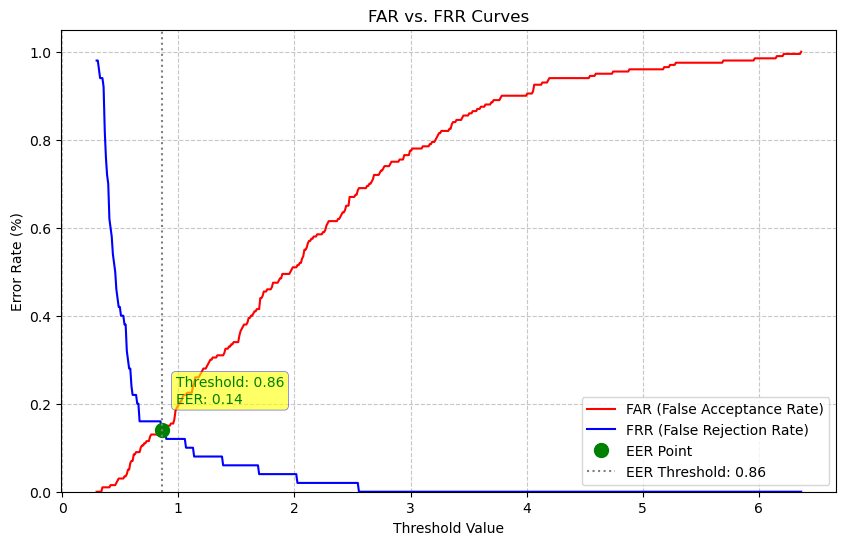

Under stimulus 5, Participant 1 vs Participant 5: EER = 0.14125000000000001
**************************************************
********************************************************************************************************************************************************************************************************


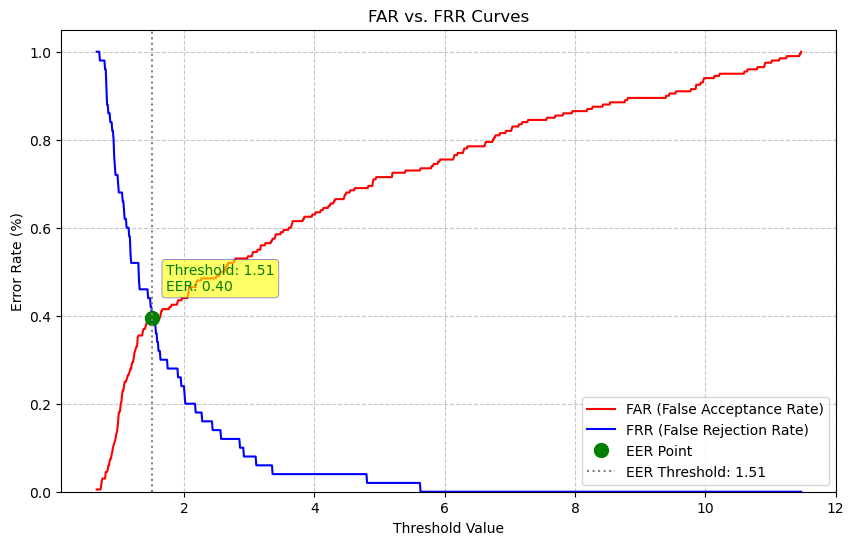

**************************************************
********************************************************************************************************************************************************************************************************


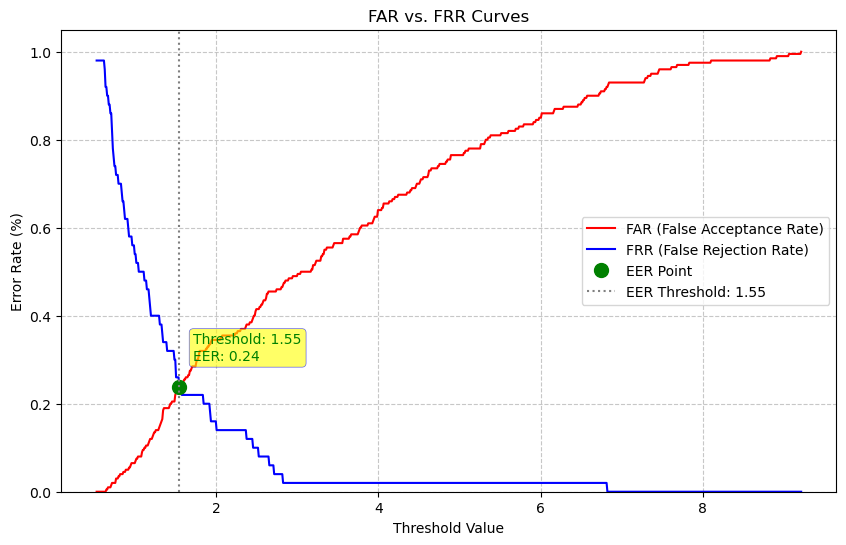

Under stimulus 6, Participant 1 vs Participant 5: EER = 0.31625000000000003
**************************************************
********************************************************************************************************************************************************************************************************


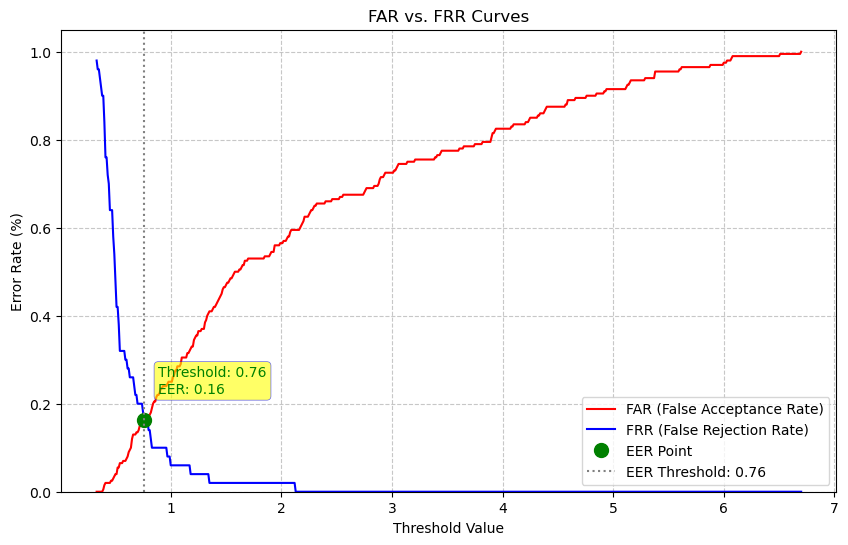

**************************************************
********************************************************************************************************************************************************************************************************


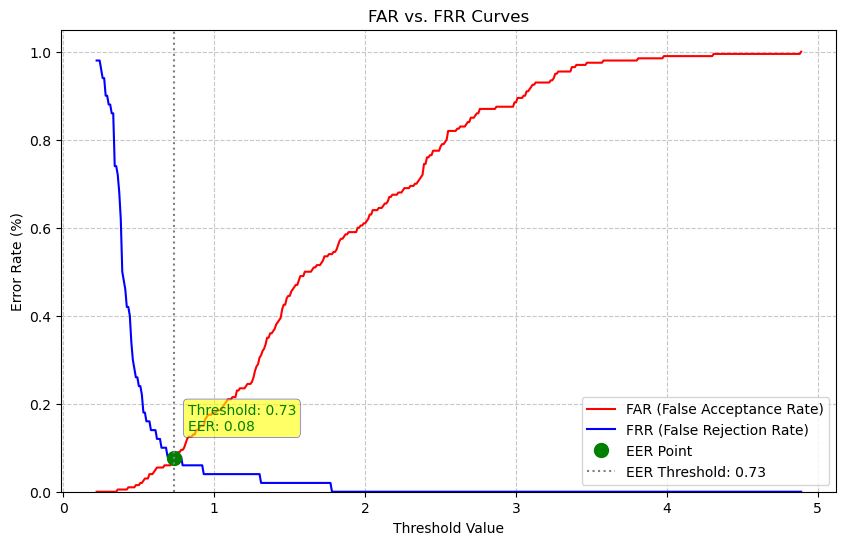

Under stimulus 7, Participant 1 vs Participant 5: EER = 0.12
**************************************************
********************************************************************************************************************************************************************************************************


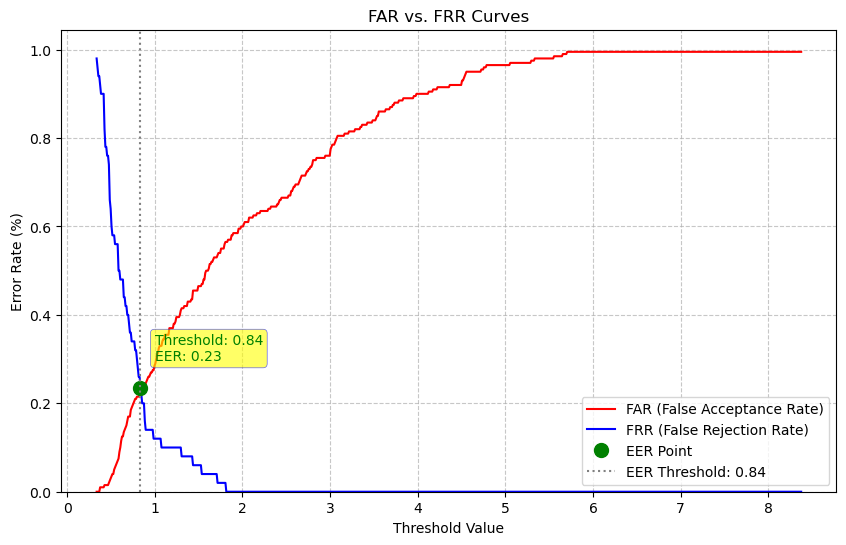

**************************************************
********************************************************************************************************************************************************************************************************


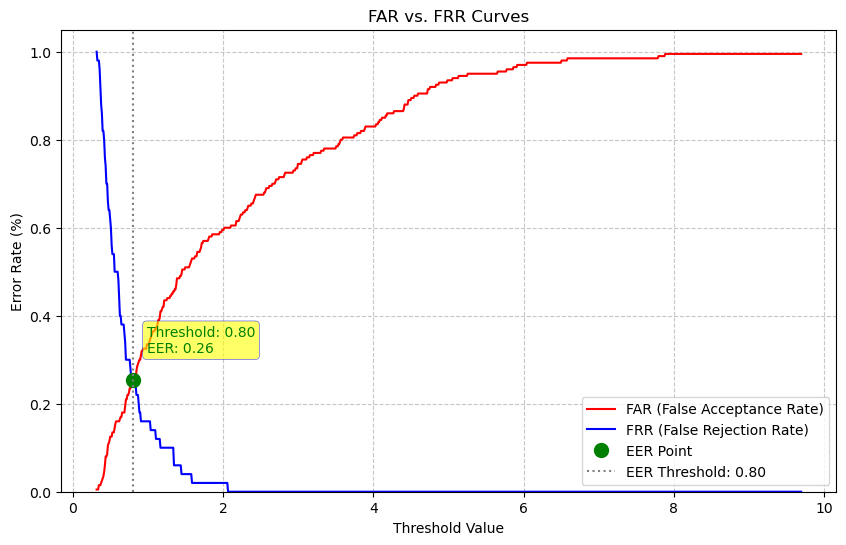

Under stimulus 8, Participant 1 vs Participant 5: EER = 0.245
**************************************************
********************************************************************************************************************************************************************************************************


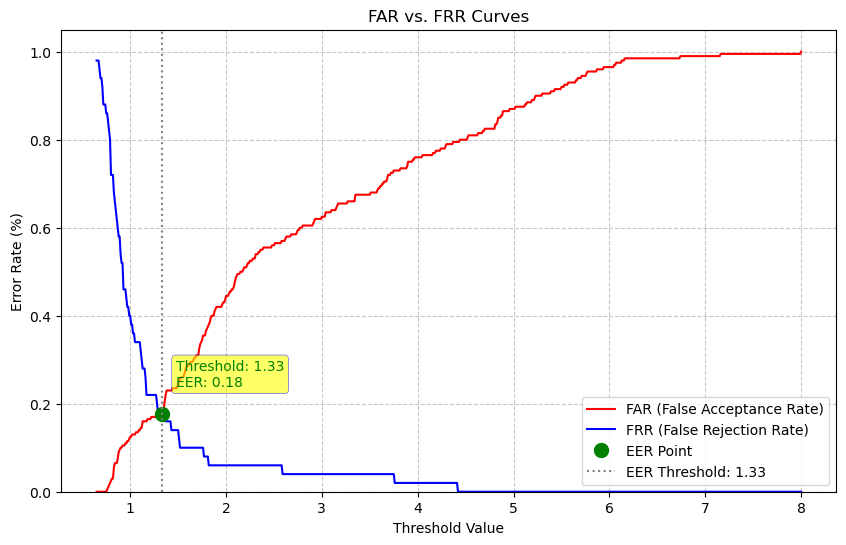

**************************************************
********************************************************************************************************************************************************************************************************


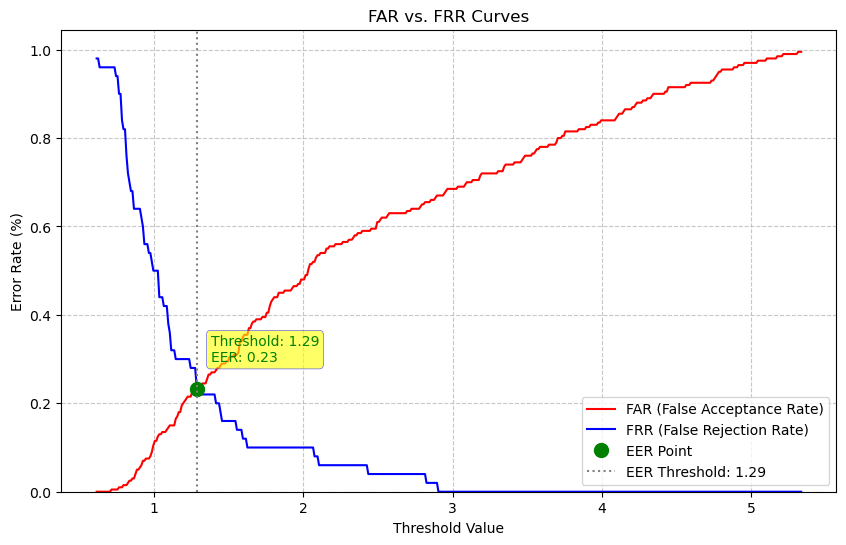

Under stimulus 1, Participant 2 vs Participant 5: EER = 0.205
**************************************************
********************************************************************************************************************************************************************************************************


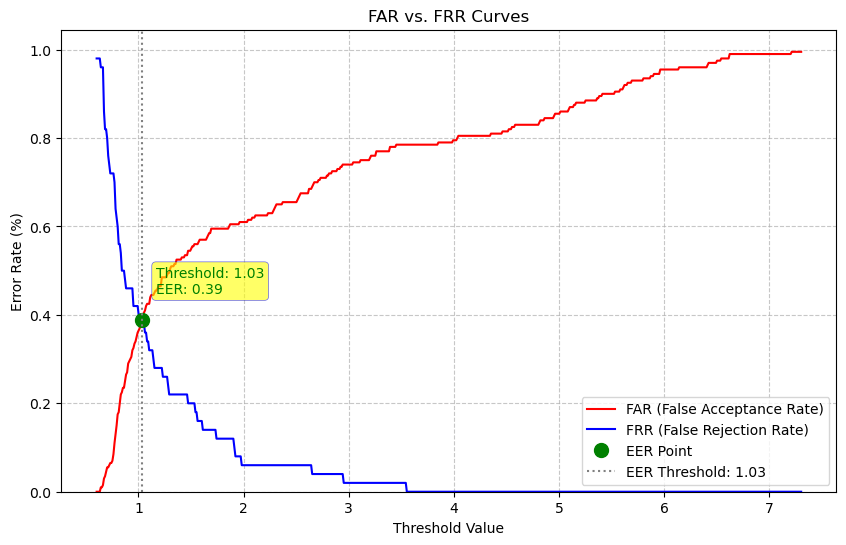

**************************************************
********************************************************************************************************************************************************************************************************


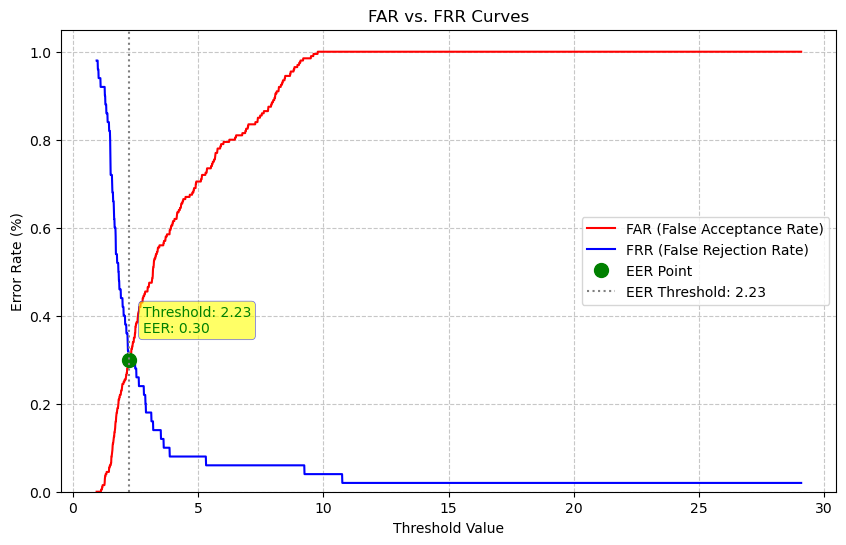

Under stimulus 2, Participant 2 vs Participant 5: EER = 0.34375
**************************************************
********************************************************************************************************************************************************************************************************


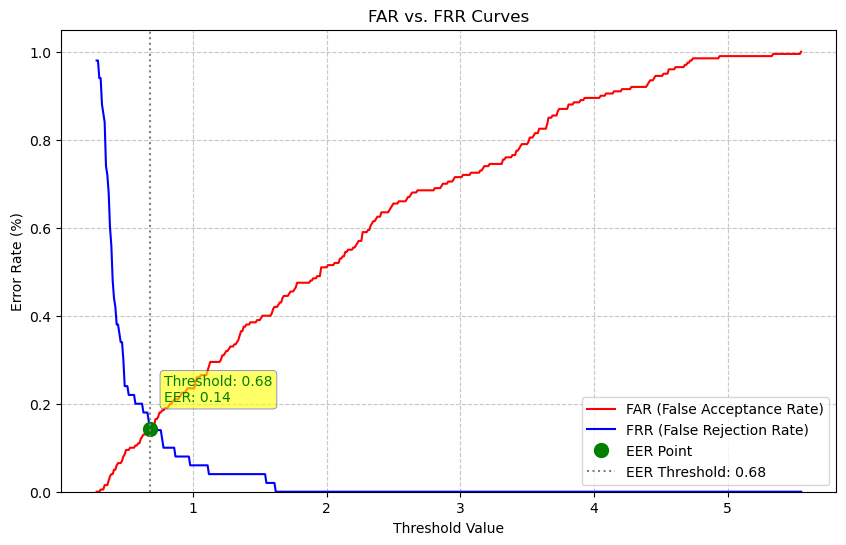

**************************************************
********************************************************************************************************************************************************************************************************


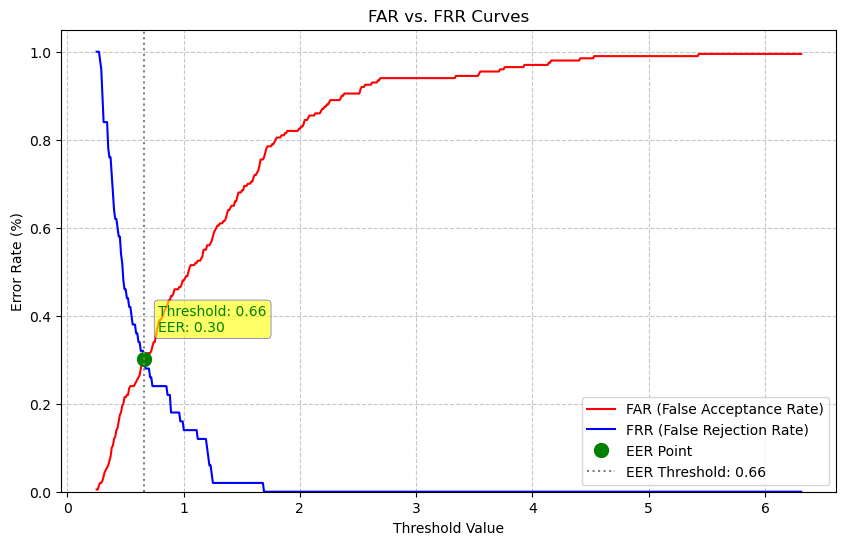

Under stimulus 3, Participant 2 vs Participant 5: EER = 0.2225
**************************************************
********************************************************************************************************************************************************************************************************


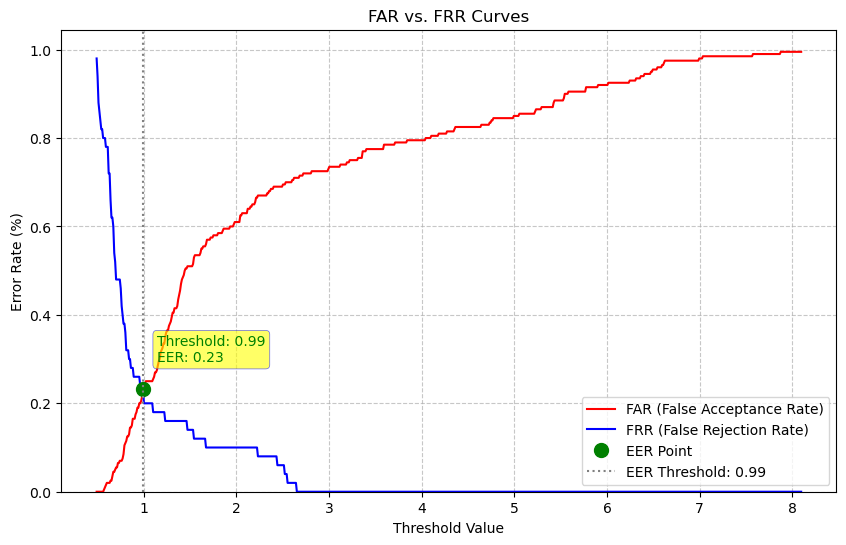

**************************************************
********************************************************************************************************************************************************************************************************


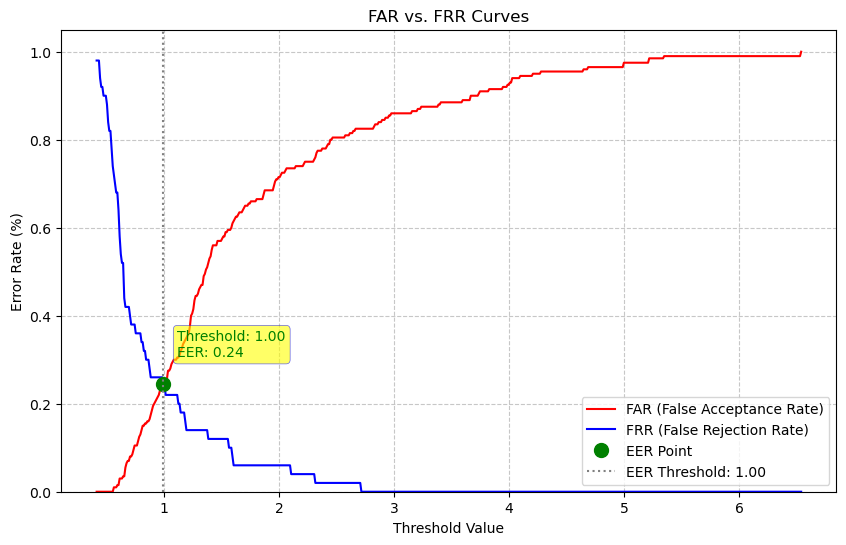

Under stimulus 4, Participant 2 vs Participant 5: EER = 0.23875
**************************************************
********************************************************************************************************************************************************************************************************


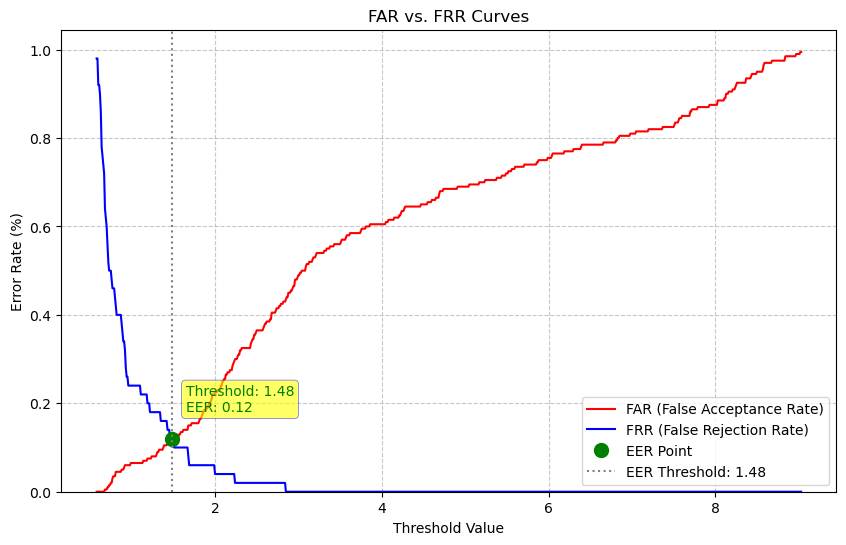

**************************************************
********************************************************************************************************************************************************************************************************


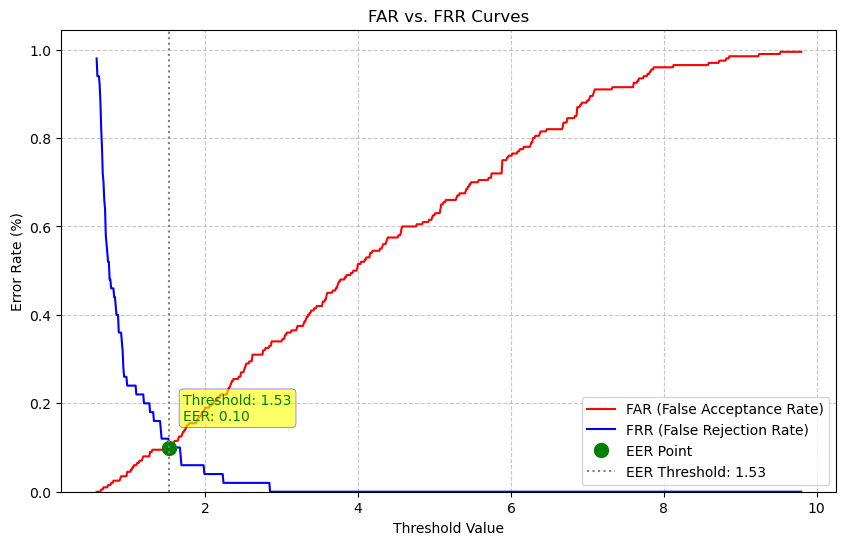

Under stimulus 5, Participant 2 vs Participant 5: EER = 0.11
**************************************************
********************************************************************************************************************************************************************************************************


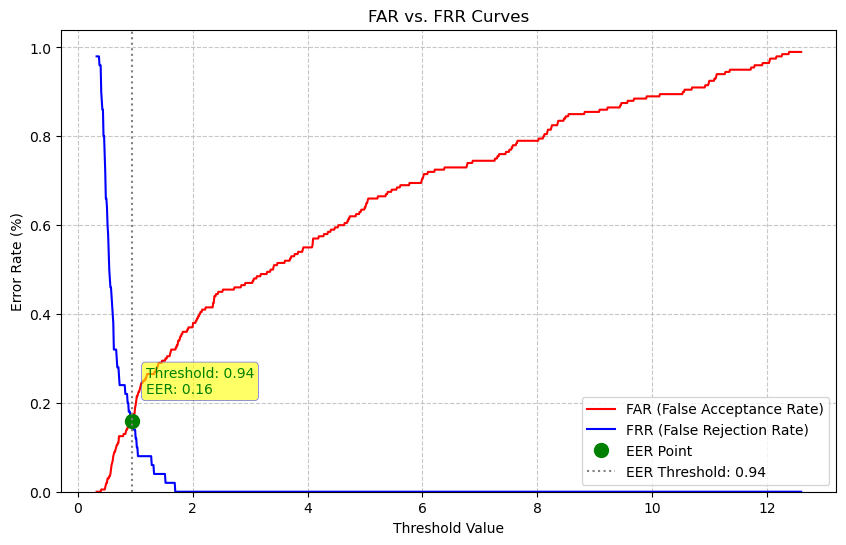

**************************************************
********************************************************************************************************************************************************************************************************


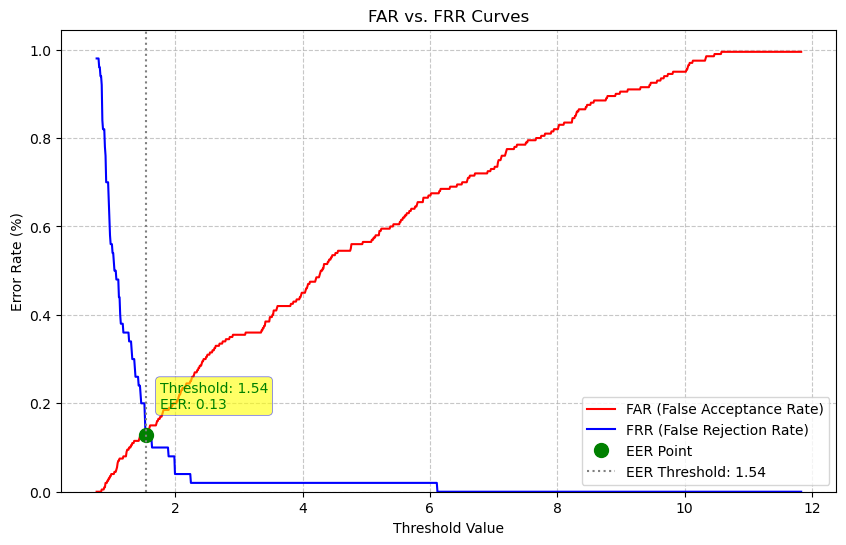

Under stimulus 6, Participant 2 vs Participant 5: EER = 0.14375
**************************************************
********************************************************************************************************************************************************************************************************


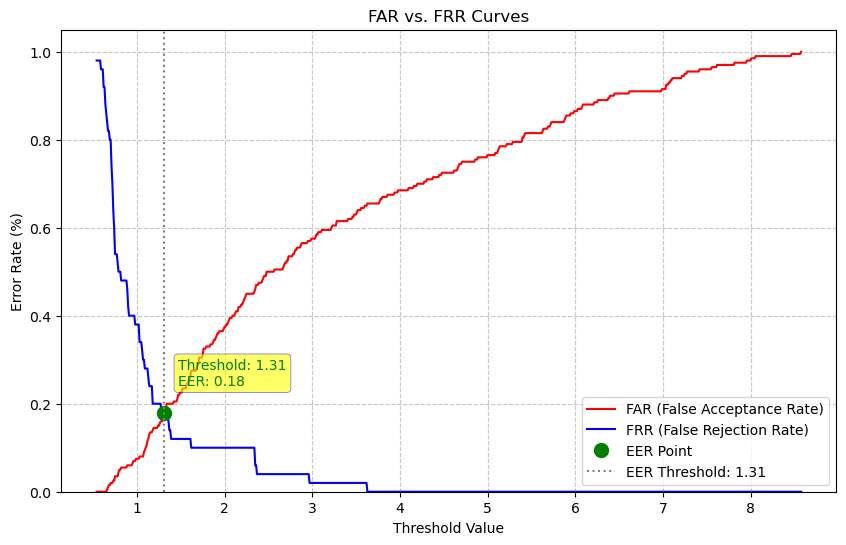

**************************************************
********************************************************************************************************************************************************************************************************


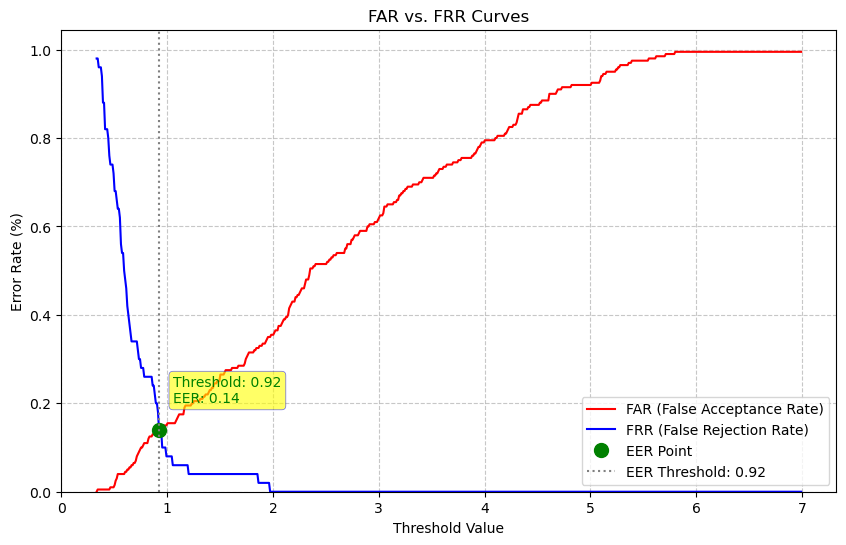

Under stimulus 7, Participant 2 vs Participant 5: EER = 0.16
**************************************************
********************************************************************************************************************************************************************************************************


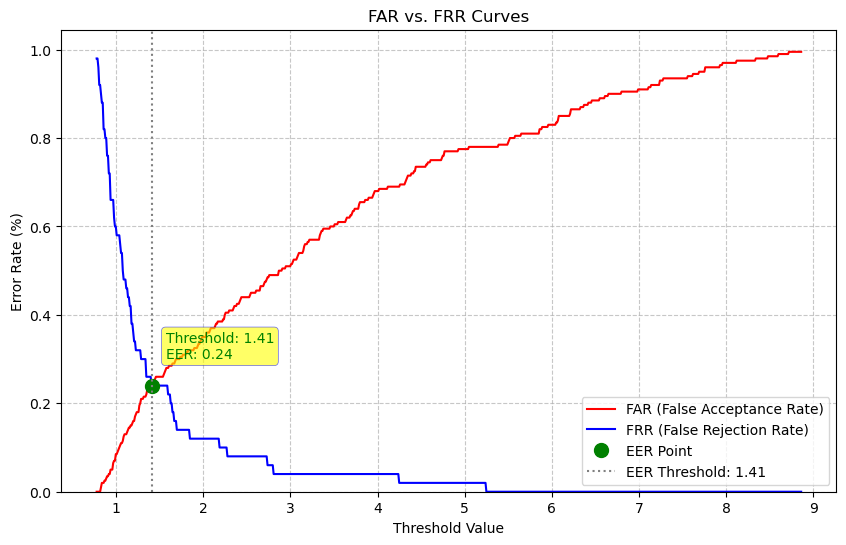

**************************************************
********************************************************************************************************************************************************************************************************


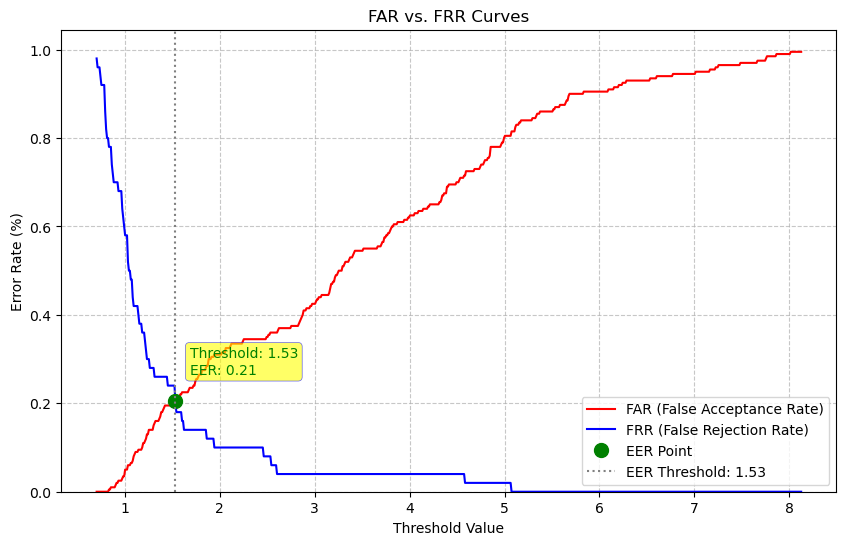

Under stimulus 8, Participant 2 vs Participant 5: EER = 0.2225
**************************************************
********************************************************************************************************************************************************************************************************


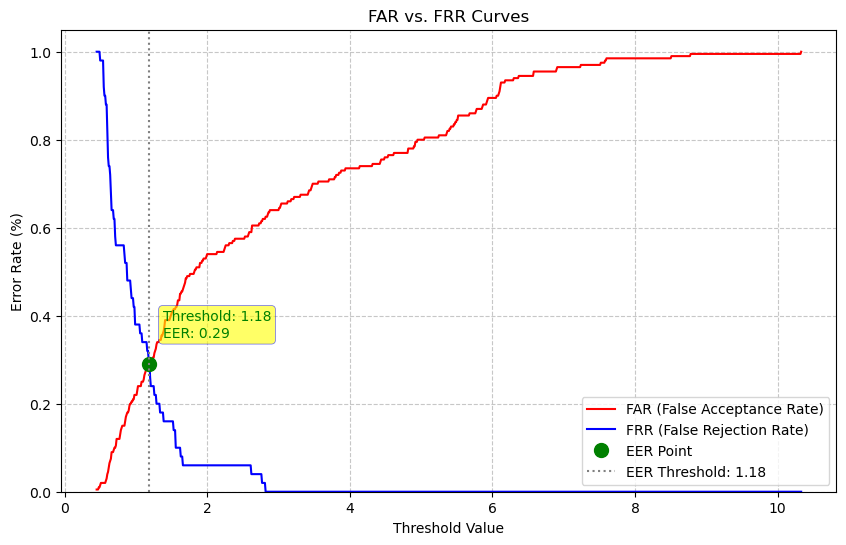

**************************************************
********************************************************************************************************************************************************************************************************


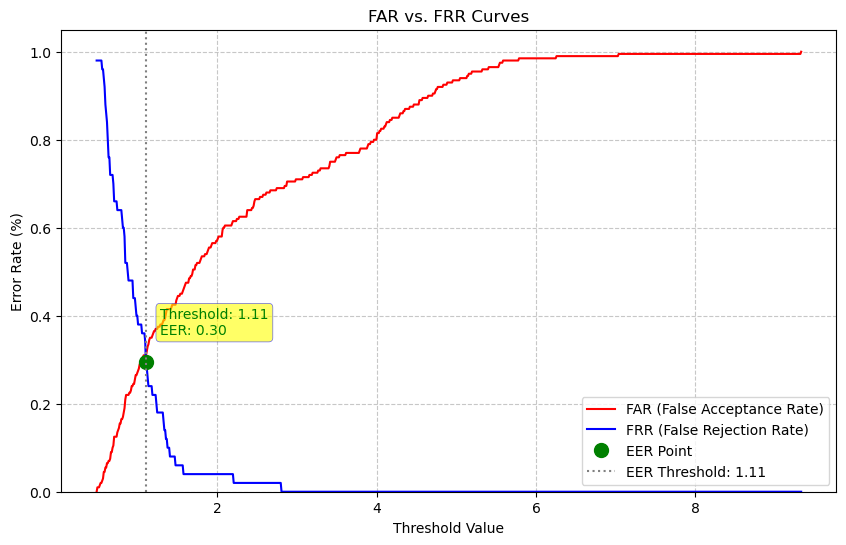

Under stimulus 1, Participant 3 vs Participant 5: EER = 0.29250000000000004
**************************************************
********************************************************************************************************************************************************************************************************


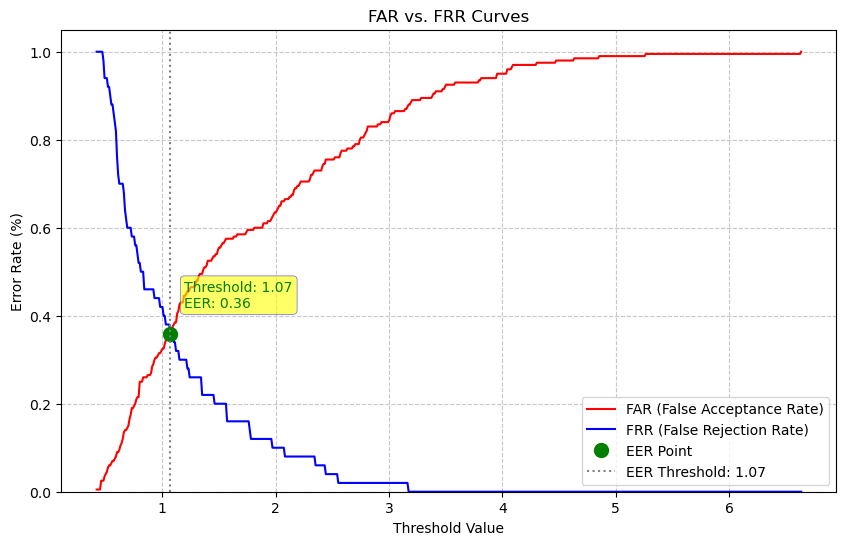

**************************************************
********************************************************************************************************************************************************************************************************


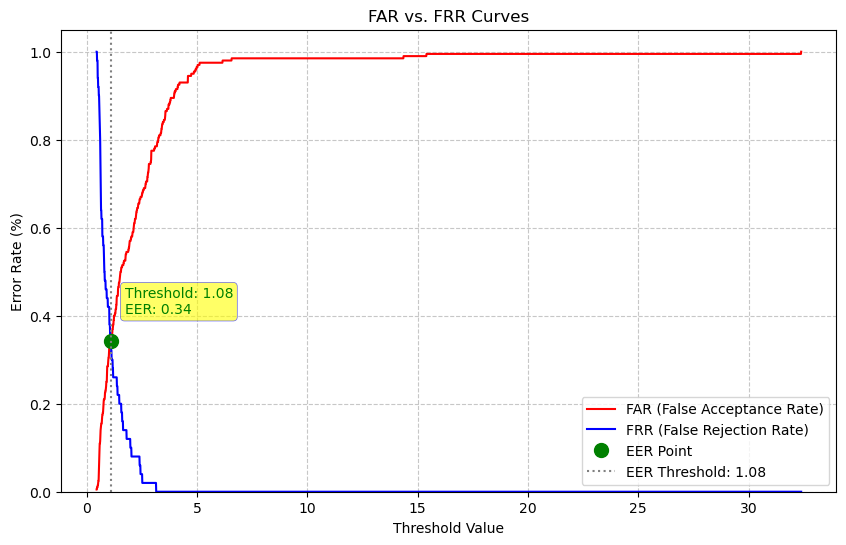

Under stimulus 2, Participant 3 vs Participant 5: EER = 0.35
**************************************************
********************************************************************************************************************************************************************************************************


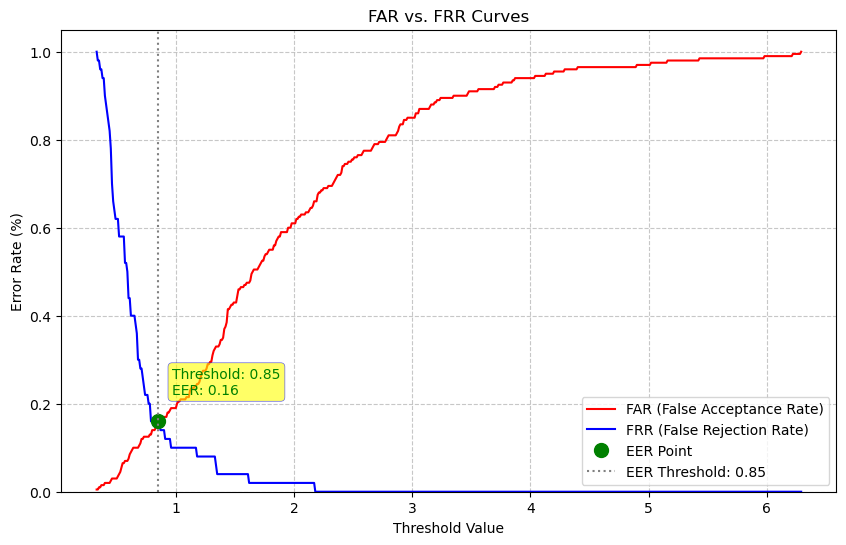

**************************************************
********************************************************************************************************************************************************************************************************


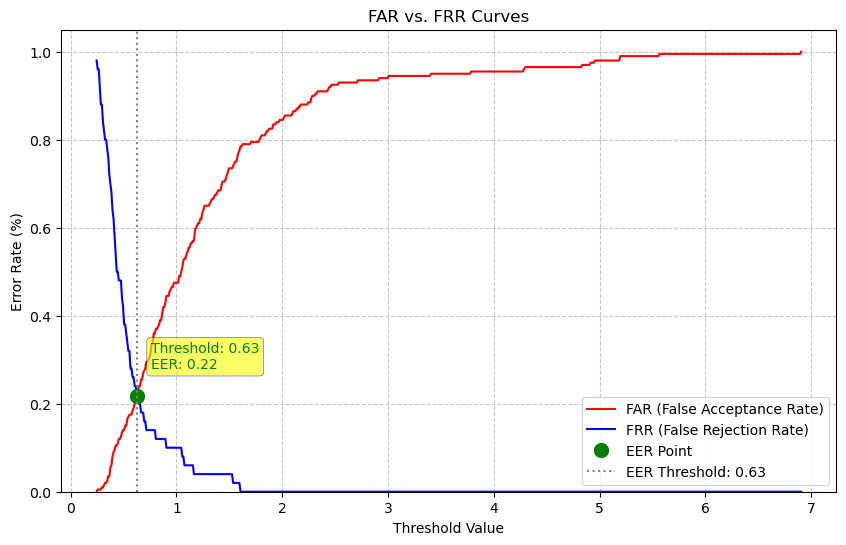

Under stimulus 3, Participant 3 vs Participant 5: EER = 0.18875
**************************************************
********************************************************************************************************************************************************************************************************


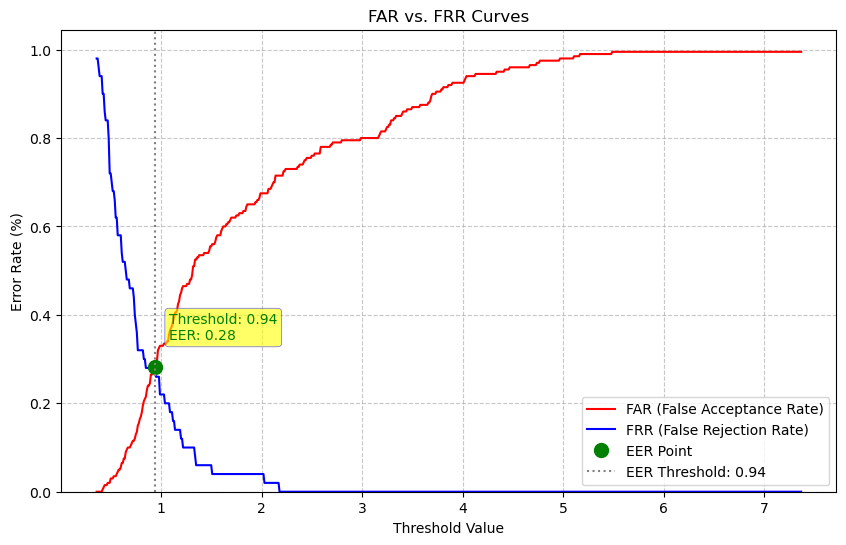

**************************************************
********************************************************************************************************************************************************************************************************


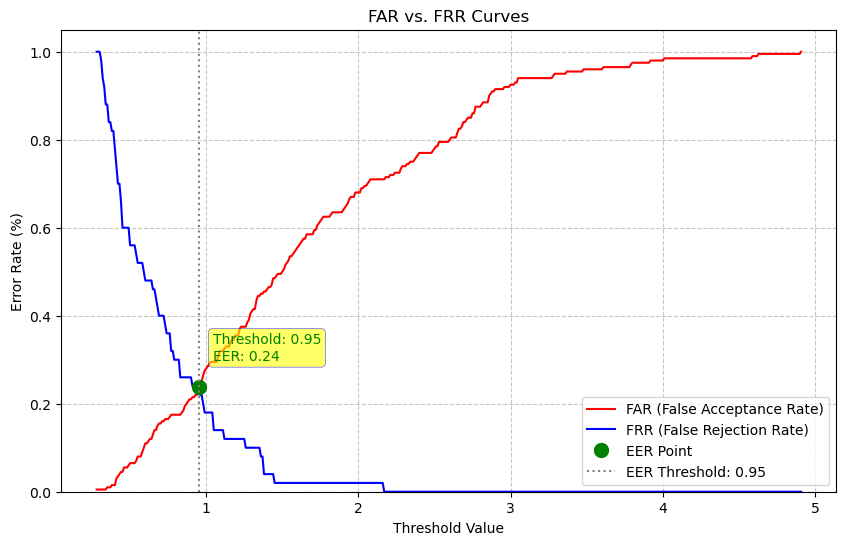

Under stimulus 4, Participant 3 vs Participant 5: EER = 0.26
**************************************************
********************************************************************************************************************************************************************************************************


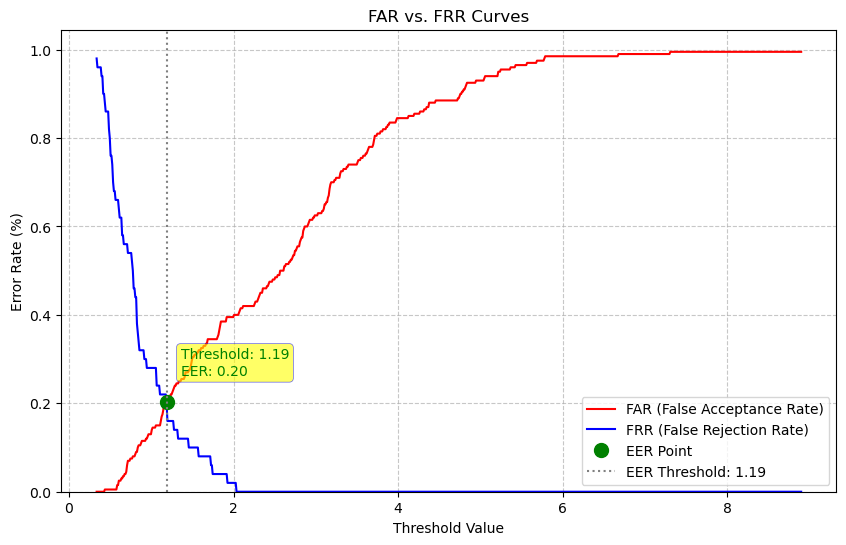

**************************************************
********************************************************************************************************************************************************************************************************


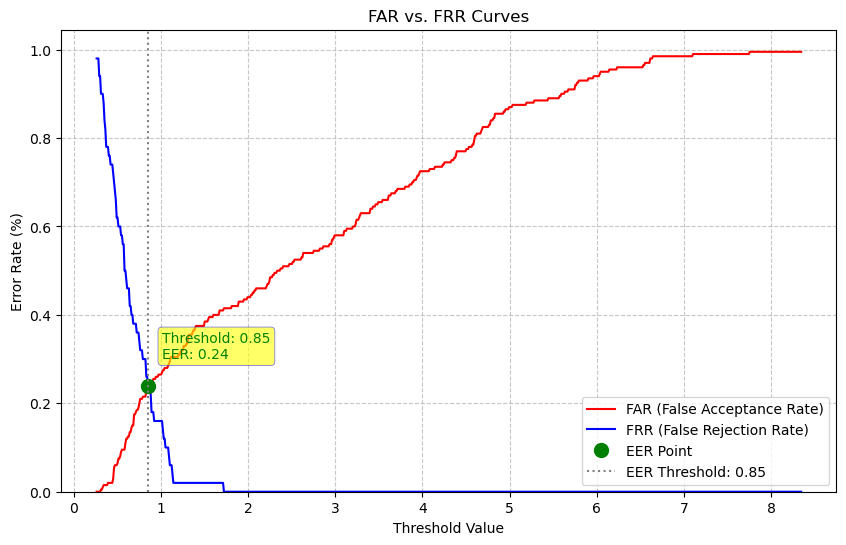

Under stimulus 5, Participant 3 vs Participant 5: EER = 0.22125
**************************************************
********************************************************************************************************************************************************************************************************


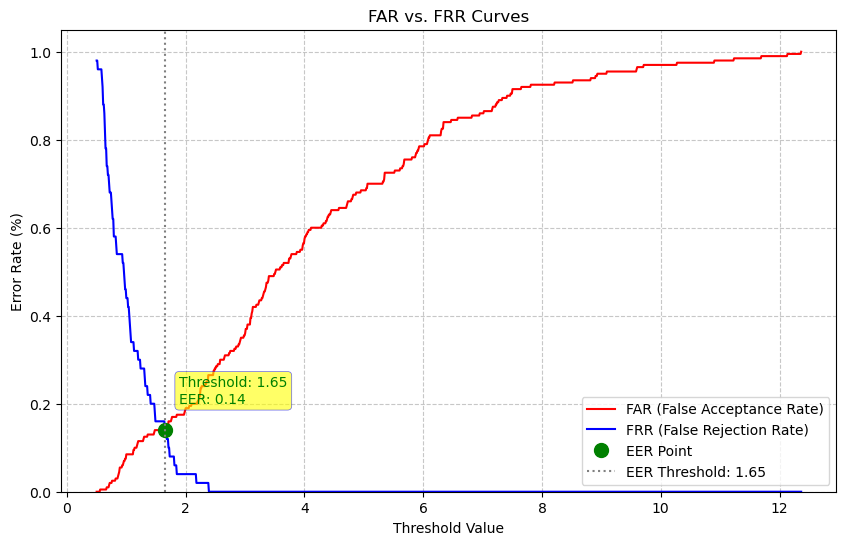

**************************************************
********************************************************************************************************************************************************************************************************


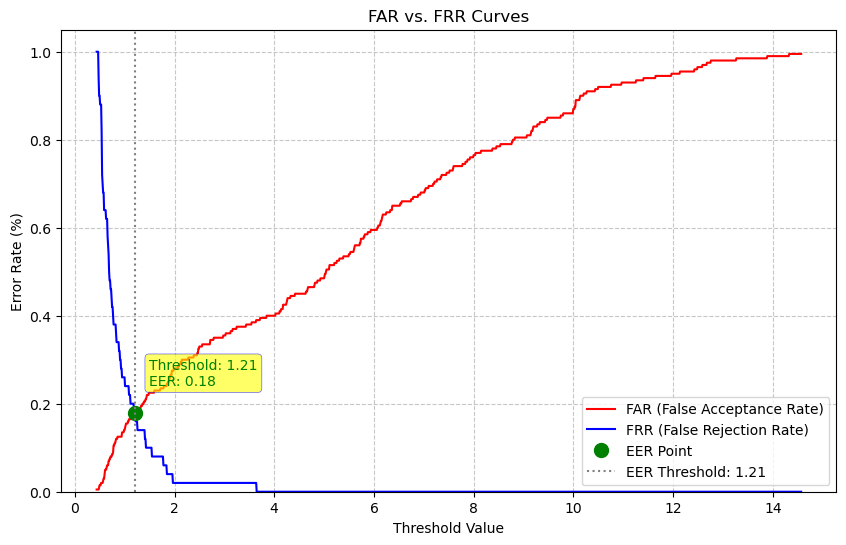

Under stimulus 6, Participant 3 vs Participant 5: EER = 0.16
**************************************************
********************************************************************************************************************************************************************************************************


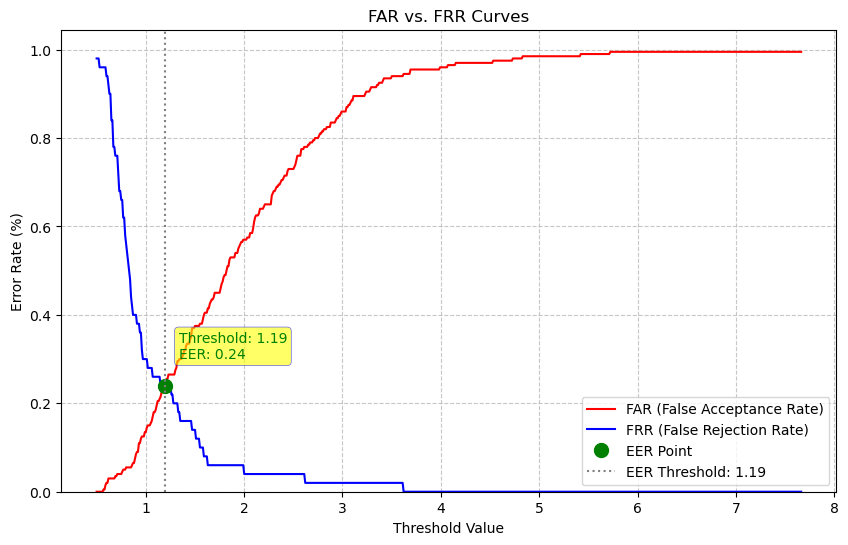

**************************************************
********************************************************************************************************************************************************************************************************


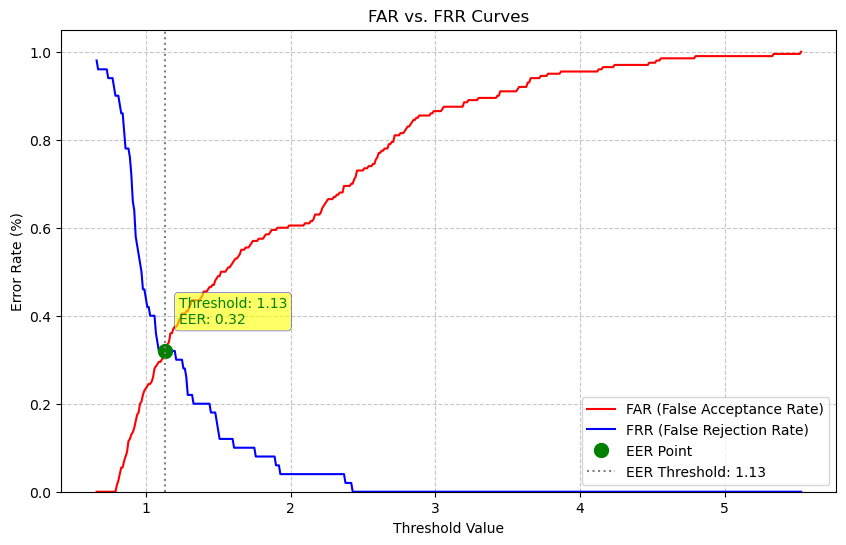

Under stimulus 7, Participant 3 vs Participant 5: EER = 0.28
**************************************************
********************************************************************************************************************************************************************************************************


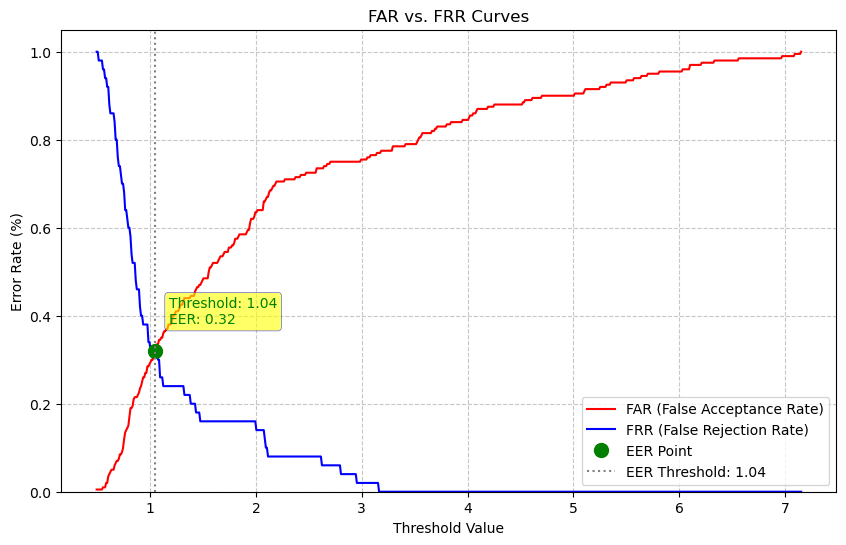

**************************************************
********************************************************************************************************************************************************************************************************


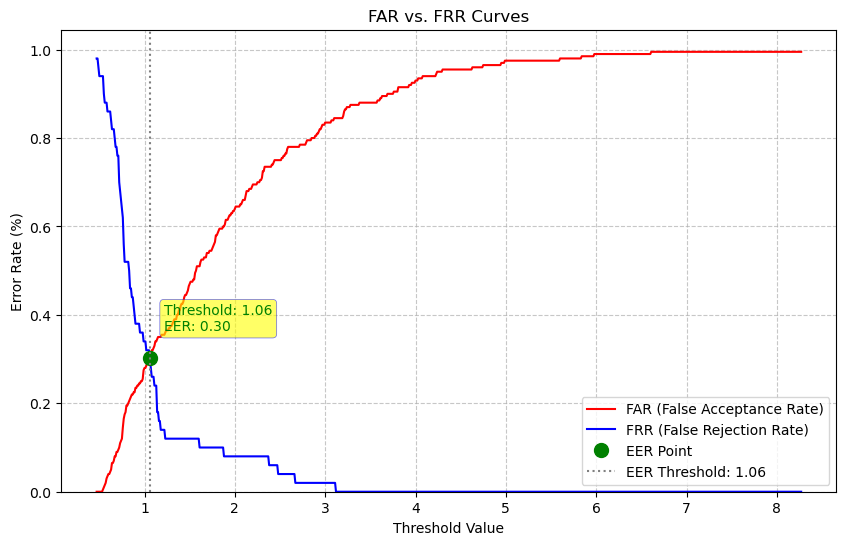

Under stimulus 8, Participant 3 vs Participant 5: EER = 0.31125
**************************************************
********************************************************************************************************************************************************************************************************


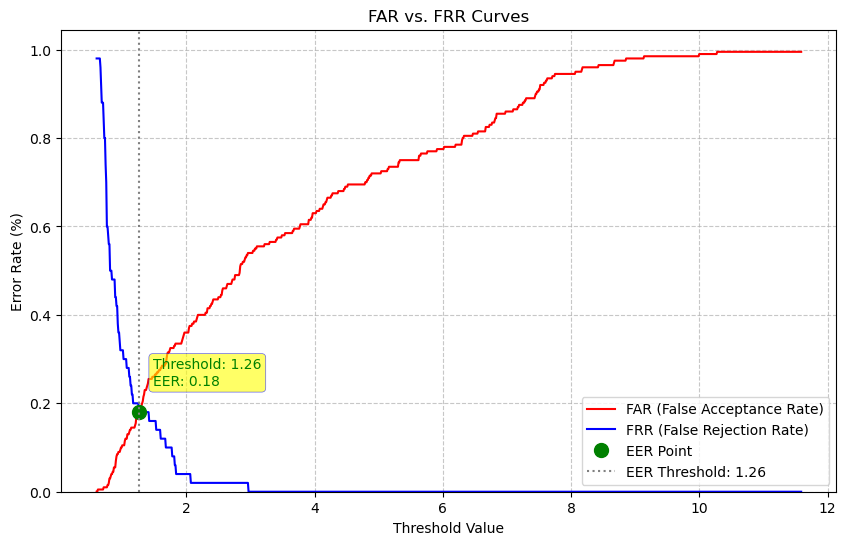

**************************************************
********************************************************************************************************************************************************************************************************


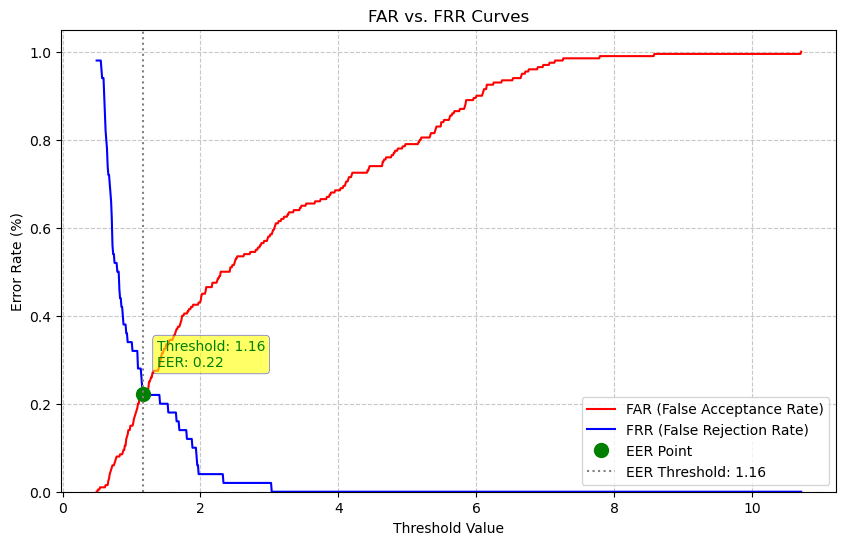

Under stimulus 1, Participant 4 vs Participant 5: EER = 0.20124999999999998
**************************************************
********************************************************************************************************************************************************************************************************


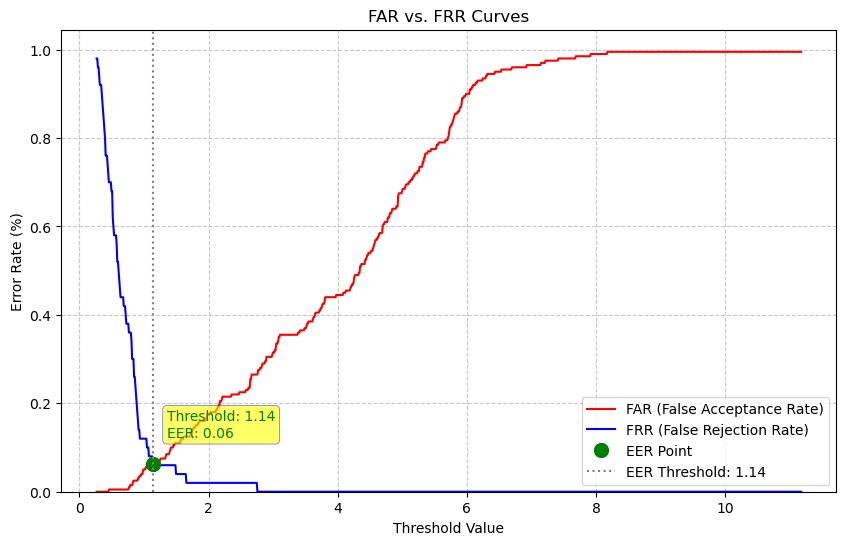

**************************************************
********************************************************************************************************************************************************************************************************


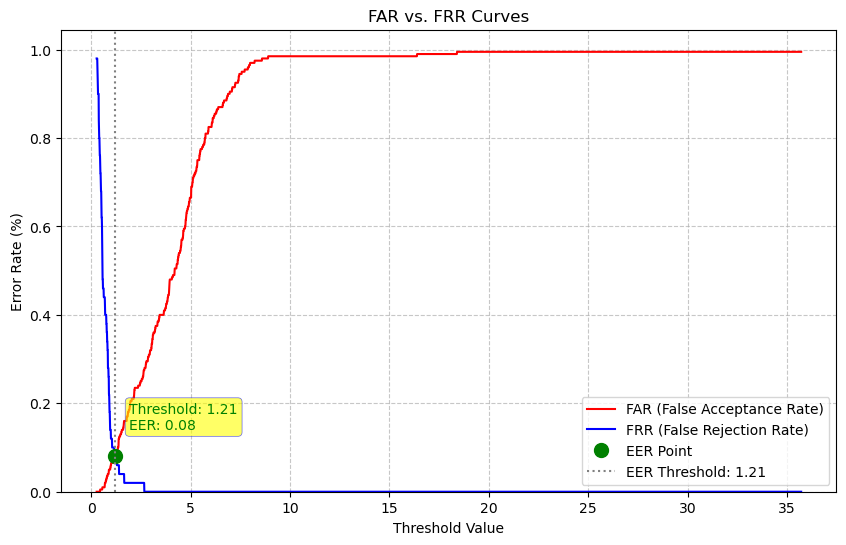

Under stimulus 2, Participant 4 vs Participant 5: EER = 0.07125000000000001
**************************************************
********************************************************************************************************************************************************************************************************


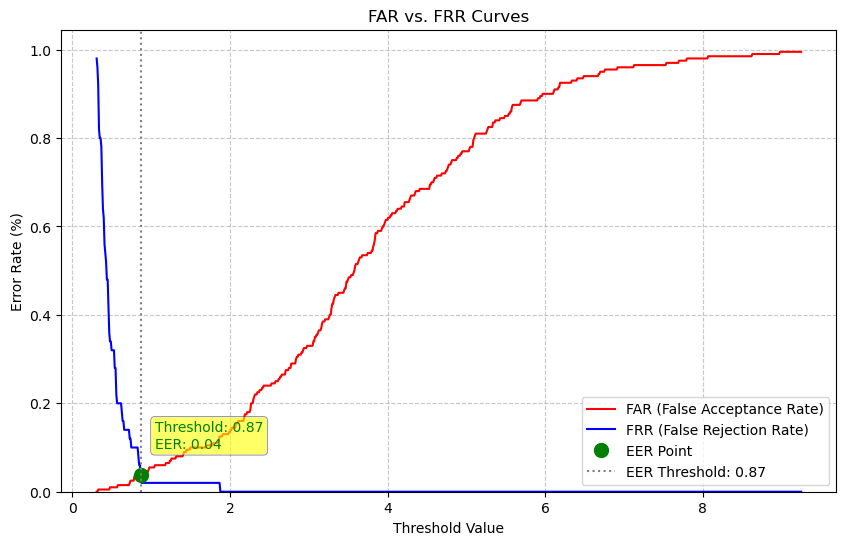

**************************************************
********************************************************************************************************************************************************************************************************


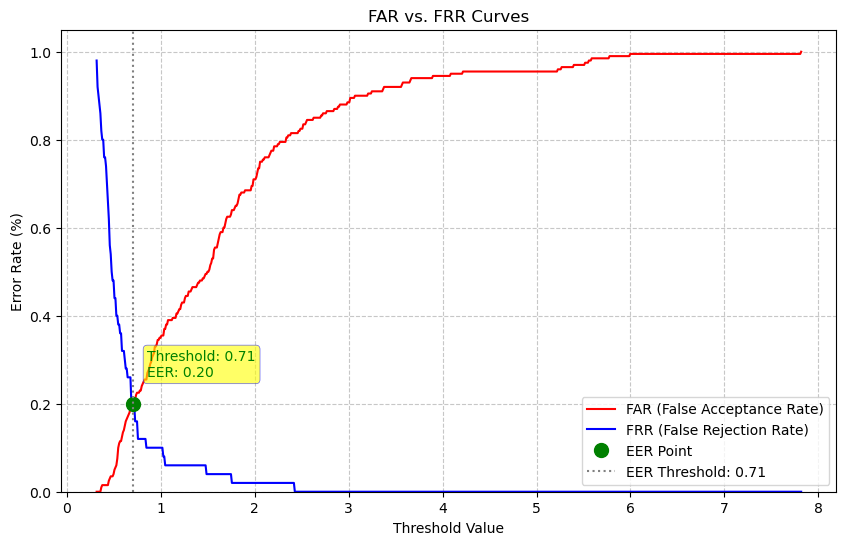

Under stimulus 3, Participant 4 vs Participant 5: EER = 0.11875000000000001
**************************************************
********************************************************************************************************************************************************************************************************


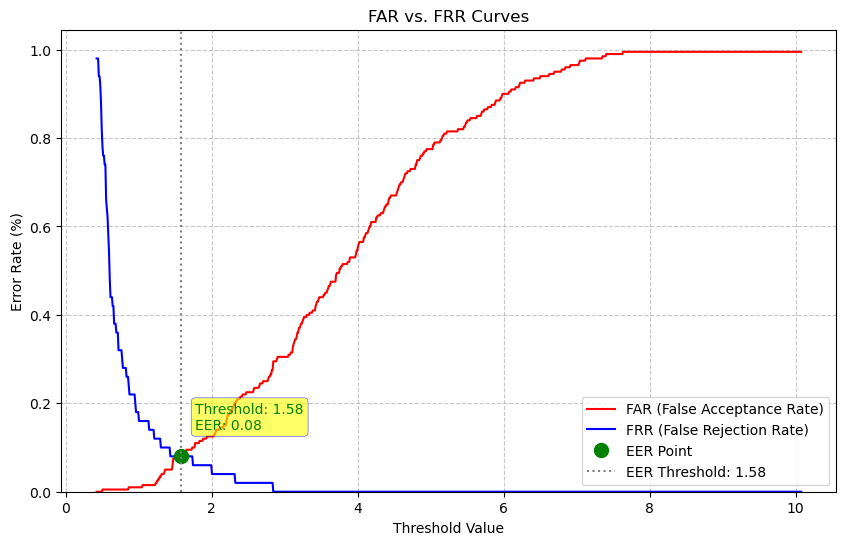

**************************************************
********************************************************************************************************************************************************************************************************


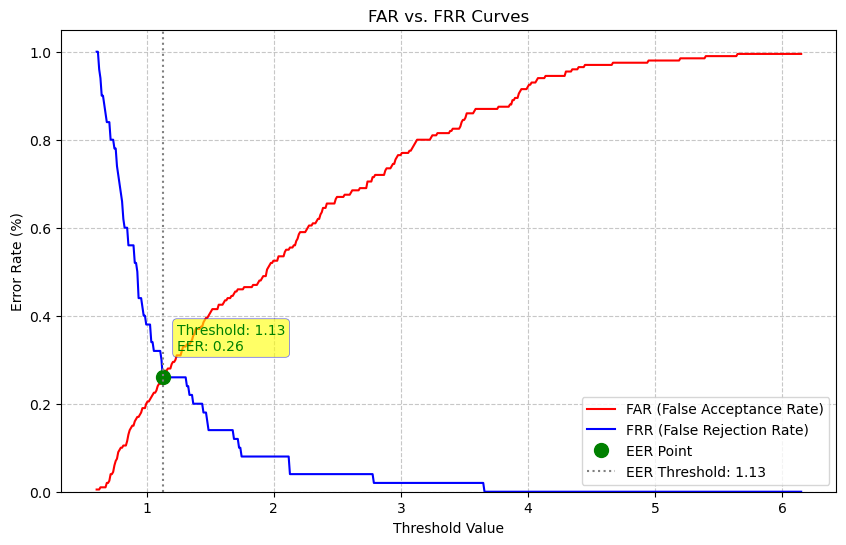

Under stimulus 4, Participant 4 vs Participant 5: EER = 0.17
**************************************************
********************************************************************************************************************************************************************************************************


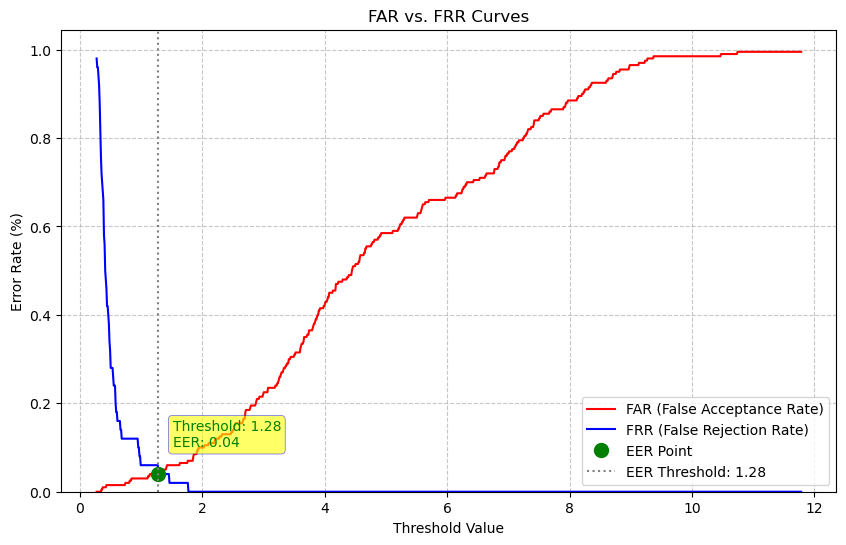

**************************************************
********************************************************************************************************************************************************************************************************


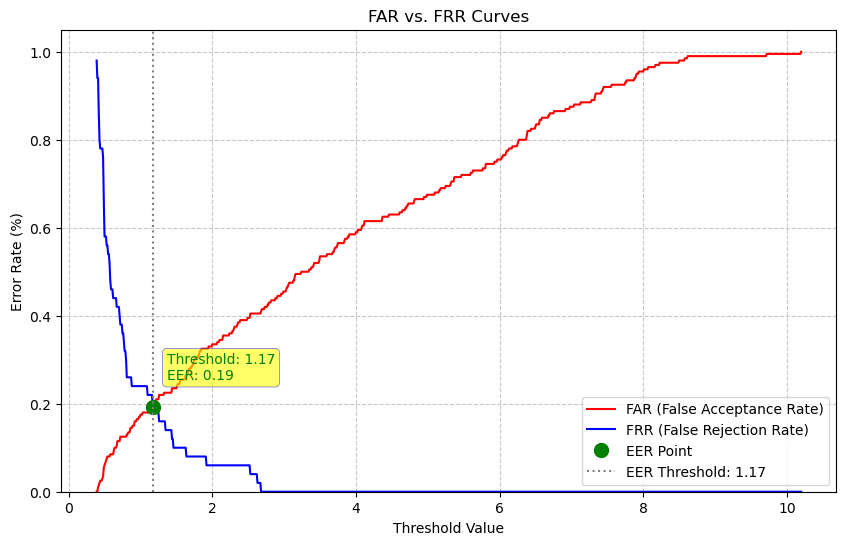

Under stimulus 5, Participant 4 vs Participant 5: EER = 0.11625
**************************************************
********************************************************************************************************************************************************************************************************


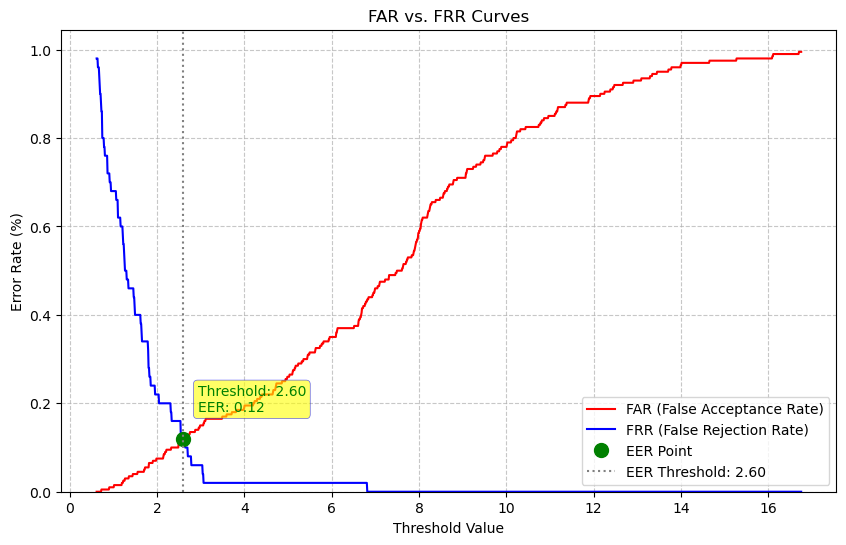

**************************************************
********************************************************************************************************************************************************************************************************


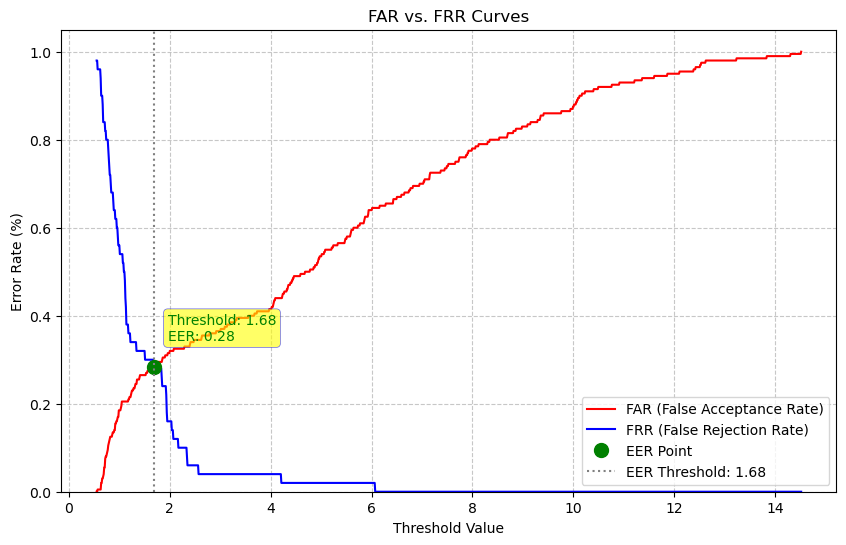

Under stimulus 6, Participant 4 vs Participant 5: EER = 0.20124999999999998
**************************************************
********************************************************************************************************************************************************************************************************


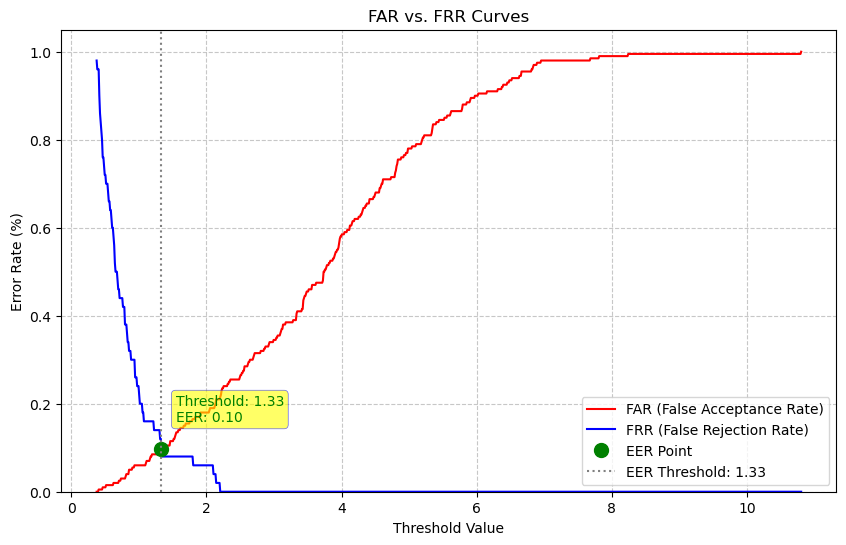

**************************************************
********************************************************************************************************************************************************************************************************


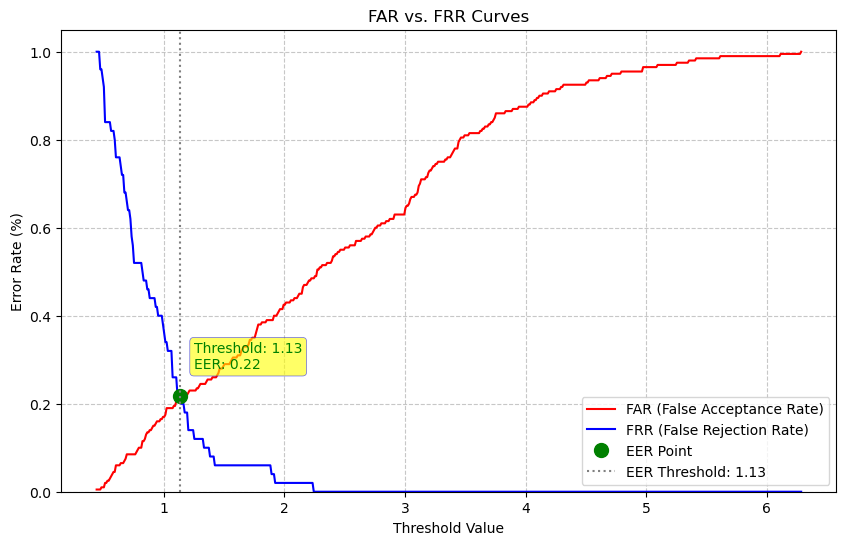

Under stimulus 7, Participant 4 vs Participant 5: EER = 0.1575
**************************************************
********************************************************************************************************************************************************************************************************


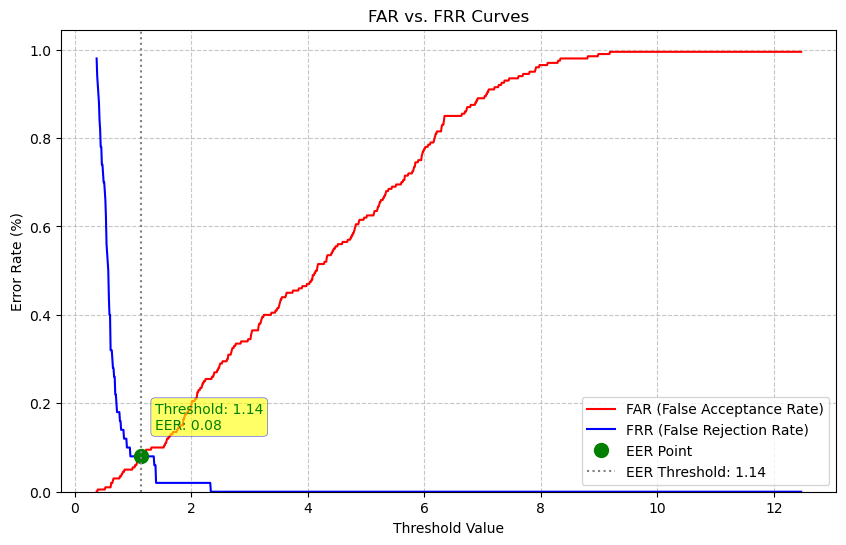

**************************************************
********************************************************************************************************************************************************************************************************


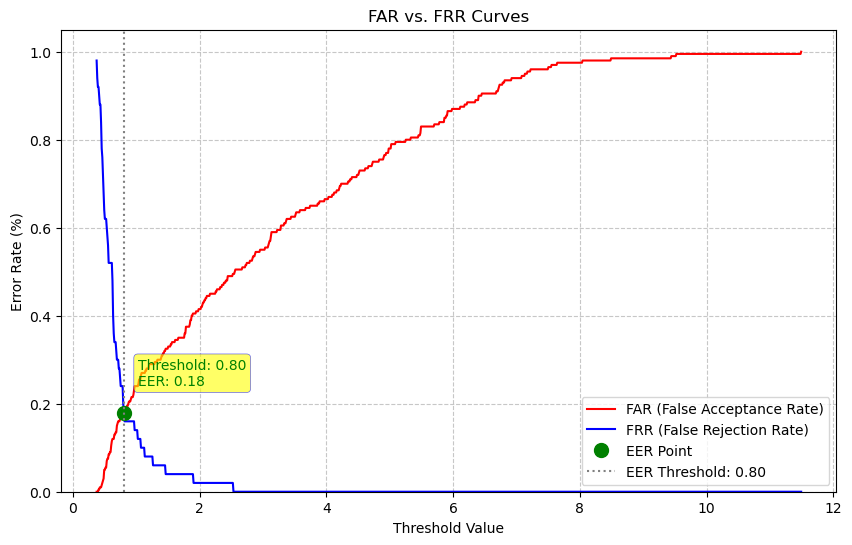

Under stimulus 8, Participant 4 vs Participant 5: EER = 0.13
**************************************************
********************************************************************************************************************************************************************************************************


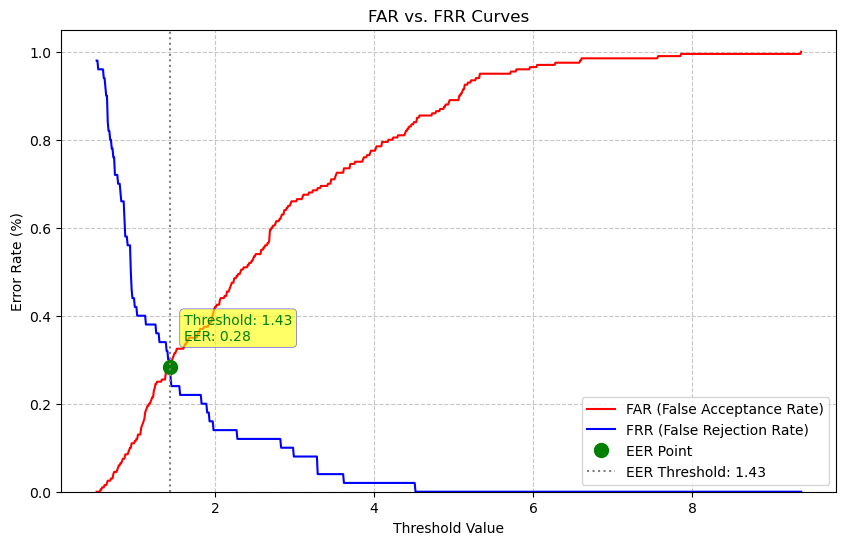

**************************************************
********************************************************************************************************************************************************************************************************


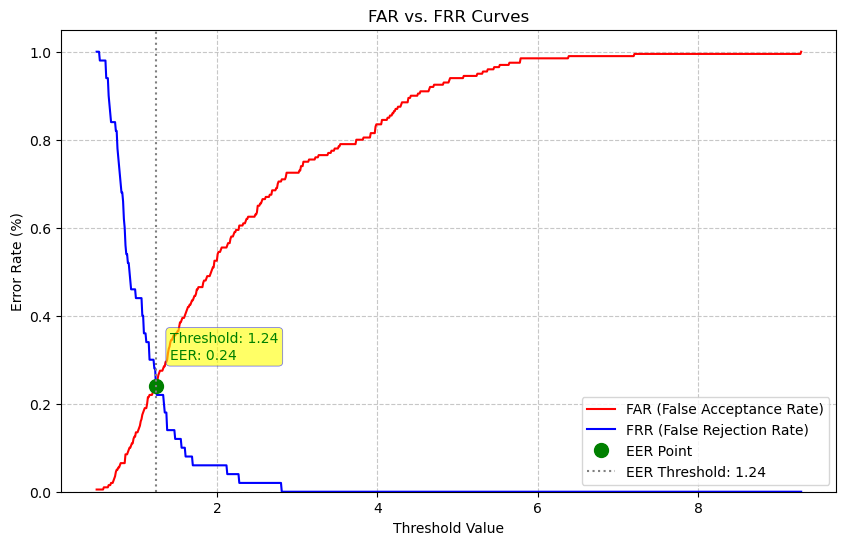

Under stimulus 1, Participant 5 vs Participant 5: EER = 0.26125
**************************************************
********************************************************************************************************************************************************************************************************


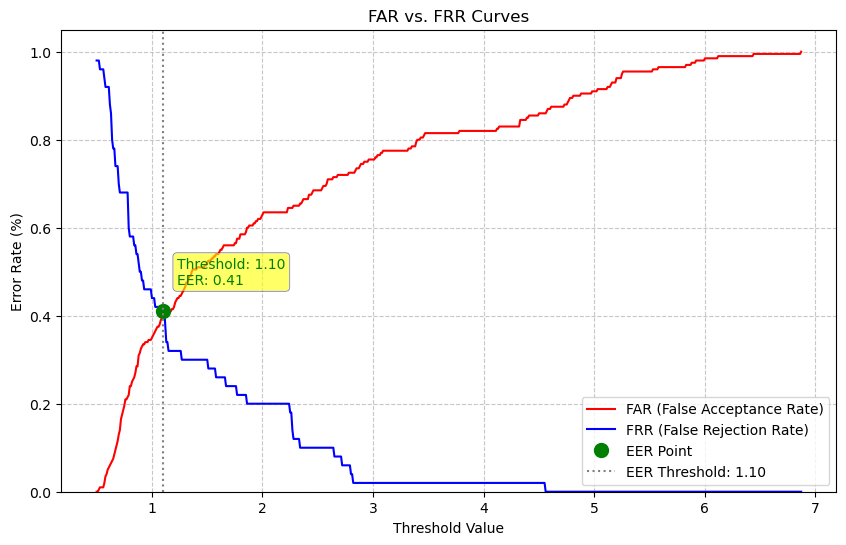

**************************************************
********************************************************************************************************************************************************************************************************


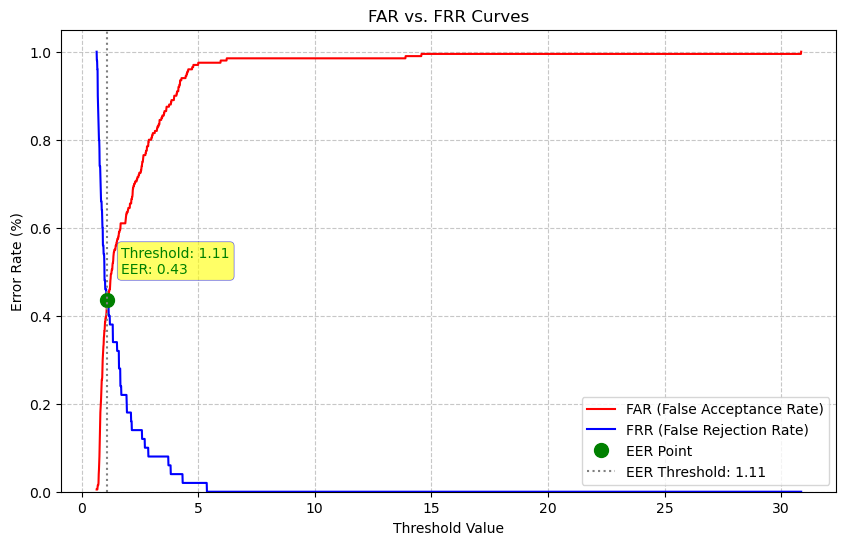

Under stimulus 2, Participant 5 vs Participant 5: EER = 0.4225
**************************************************
********************************************************************************************************************************************************************************************************


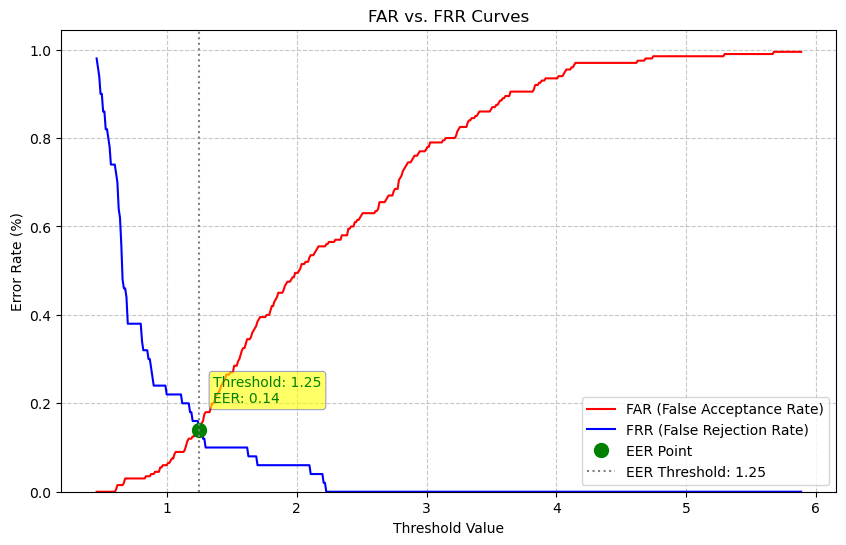

**************************************************
********************************************************************************************************************************************************************************************************


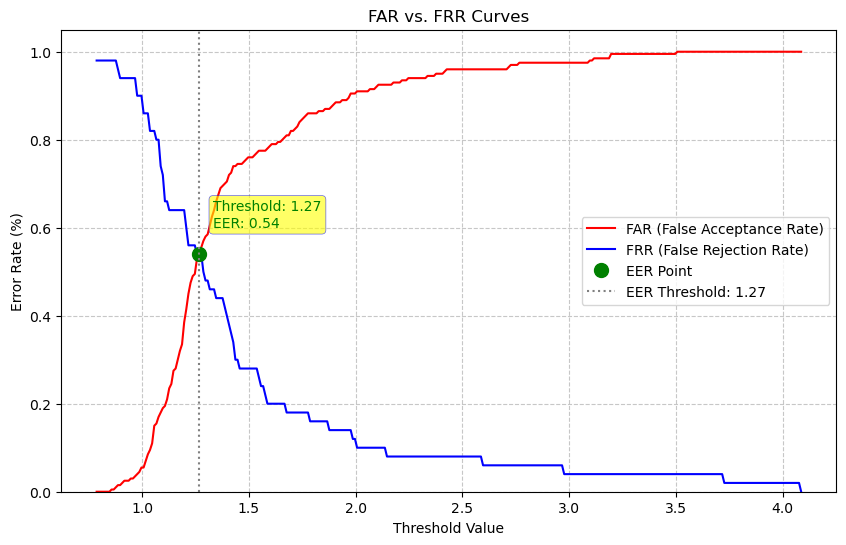

Under stimulus 3, Participant 5 vs Participant 5: EER = 0.34
**************************************************
********************************************************************************************************************************************************************************************************


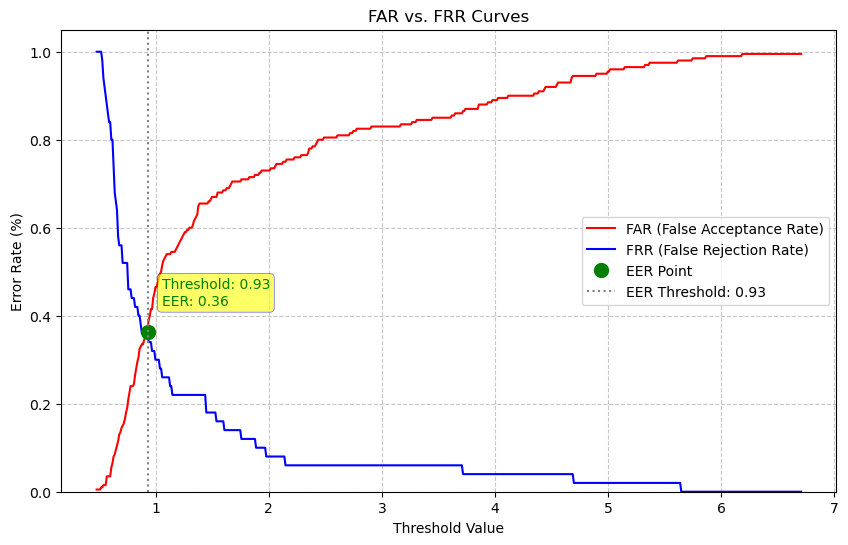

**************************************************
********************************************************************************************************************************************************************************************************


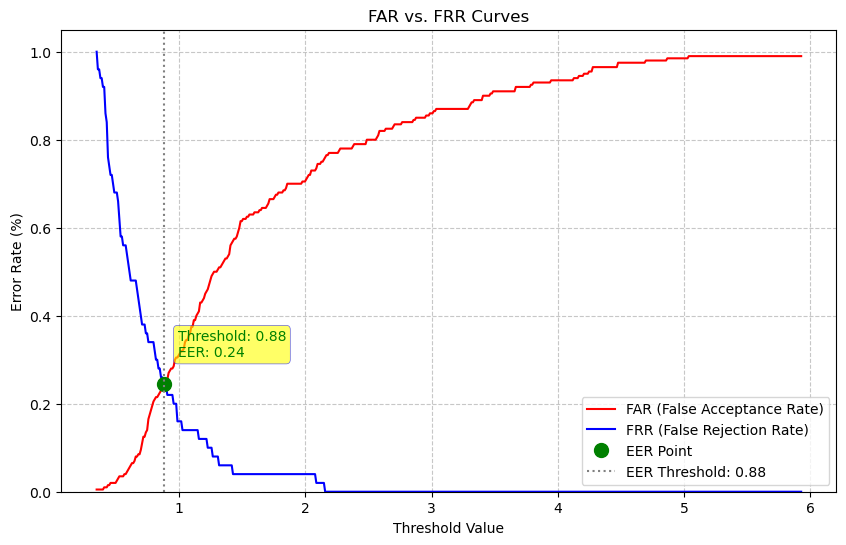

Under stimulus 4, Participant 5 vs Participant 5: EER = 0.30374999999999996
**************************************************
********************************************************************************************************************************************************************************************************


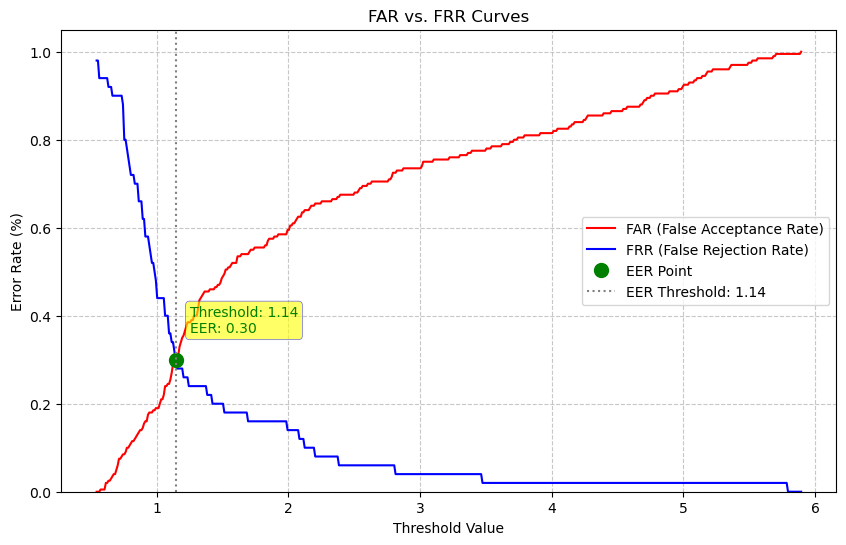

**************************************************
********************************************************************************************************************************************************************************************************


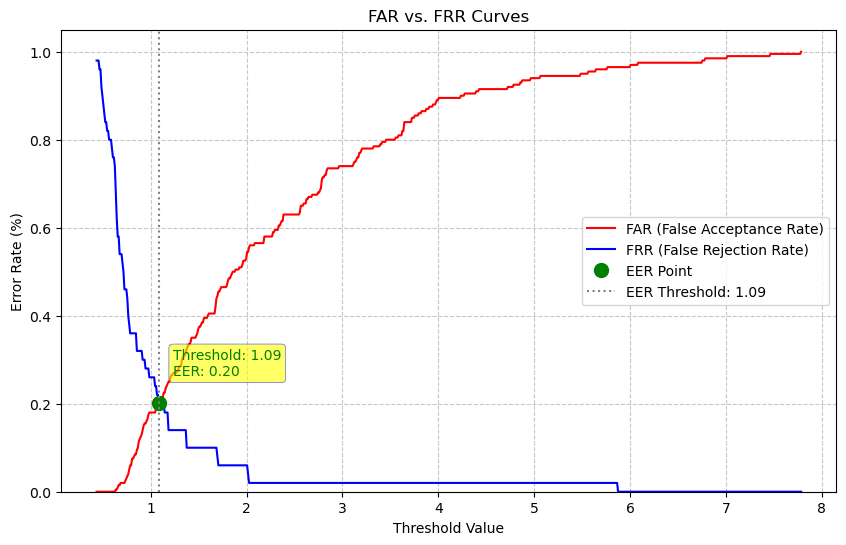

Under stimulus 5, Participant 5 vs Participant 5: EER = 0.25125
**************************************************
********************************************************************************************************************************************************************************************************


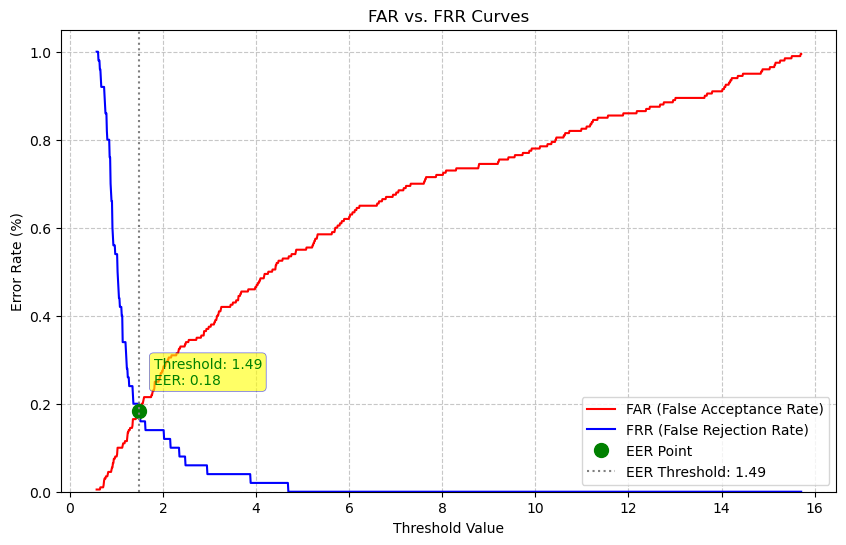

**************************************************
********************************************************************************************************************************************************************************************************


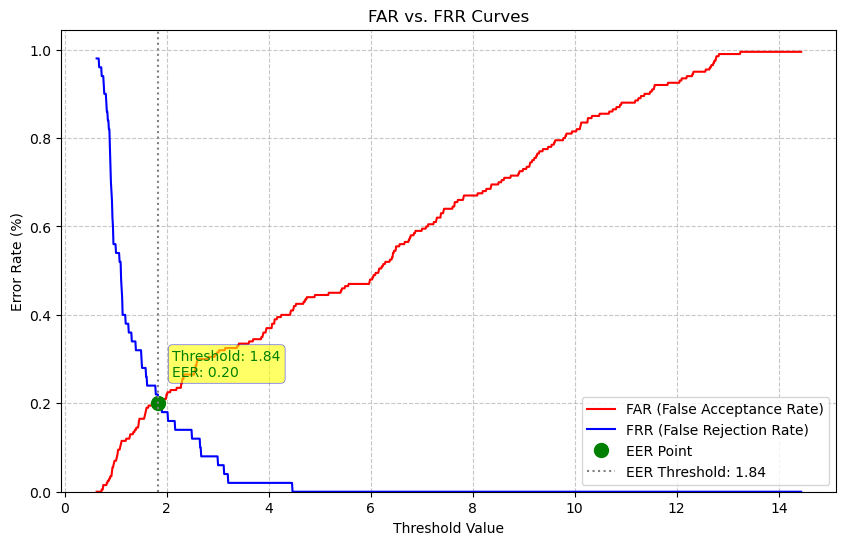

Under stimulus 6, Participant 5 vs Participant 5: EER = 0.19125
**************************************************
********************************************************************************************************************************************************************************************************


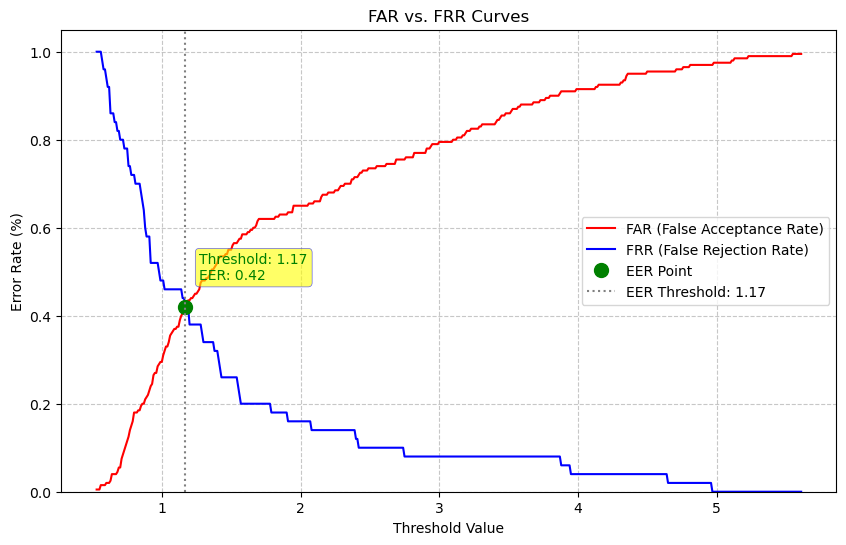

**************************************************
********************************************************************************************************************************************************************************************************


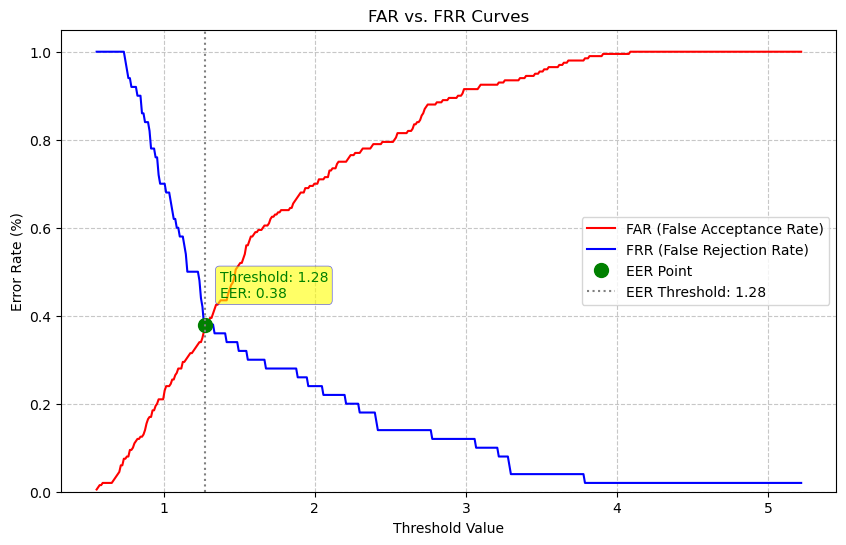

Under stimulus 7, Participant 5 vs Participant 5: EER = 0.4
**************************************************
********************************************************************************************************************************************************************************************************


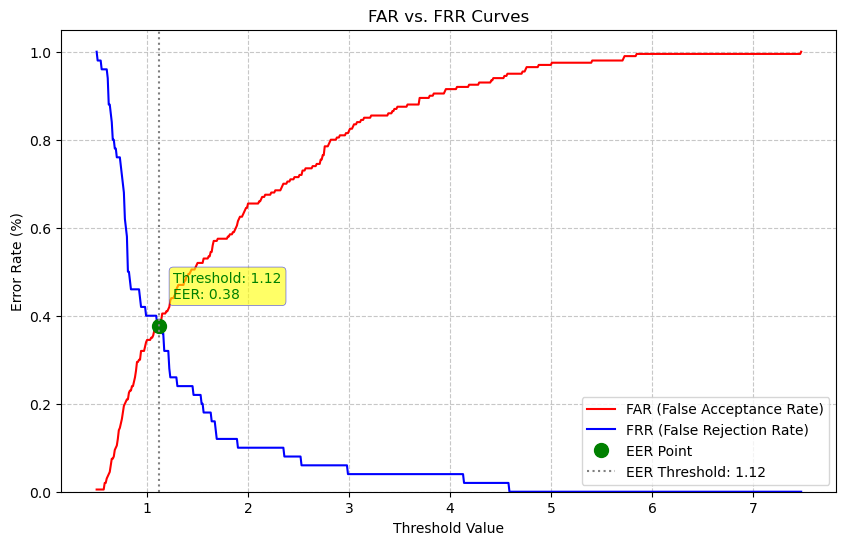

**************************************************
********************************************************************************************************************************************************************************************************


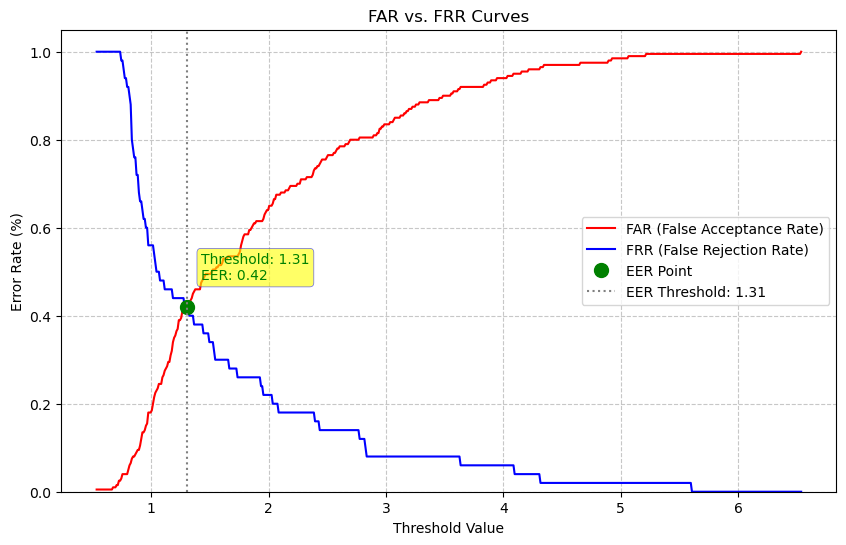

Under stimulus 8, Participant 5 vs Participant 5: EER = 0.39875


In [250]:
compute_threshold_for_experiment2()

In [251]:
EER_for_experiment2

[[0.08,
  0.195,
  0.14375,
  0.22875,
  0.14125000000000001,
  0.31625000000000003,
  0.12,
  0.245],
 [0.205, 0.34375, 0.2225, 0.23875, 0.11, 0.14375, 0.16, 0.2225],
 [0.29250000000000004, 0.35, 0.18875, 0.26, 0.22125, 0.16, 0.28, 0.31125],
 [0.20124999999999998,
  0.07125000000000001,
  0.11875000000000001,
  0.17,
  0.11625,
  0.20124999999999998,
  0.1575,
  0.13],
 [0.26125, 0.4225, 0.34, 0.30374999999999996, 0.25125, 0.19125, 0.4, 0.39875]]

### Read & Store EERs with .json

In [253]:
with open("EER_data_for_experiment2.json", 'w') as f:
    # indent=4 で整形して読みやすくする
    json.dump(EER_for_experiment2, f, indent=4)

In [254]:
stimuli = [0] * 8
for participant in EER_for_experiment2:
    for stimulus_index in range(len(participant)):
        stimuli[stimulus_index] += participant[stimulus_index]

for stimulus_index in range(len(stimuli)):
    print(f"stimulus {stimulus_index}'s mean EER = {stimuli[stimulus_index] / 5}")

stimulus 0's mean EER = 0.20800000000000002
stimulus 1's mean EER = 0.2765
stimulus 2's mean EER = 0.20274999999999999
stimulus 3's mean EER = 0.24025
stimulus 4's mean EER = 0.16799999999999998
stimulus 5's mean EER = 0.20249999999999999
stimulus 6's mean EER = 0.22350000000000003
stimulus 7's mean EER = 0.2615
